## Network Pruning

Previously we have succesfully find winning tickets with iterative pruning strategies

In this notebook we will try to prune the network itself

### Fourth Version

Hopefully the final version
 
1. Make the loop for the rounds
2. and the experiment will be ready

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import os
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, datasets
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
from sklearn.metrics import accuracy_score, precision_score, recall_score
from load_MNIST import load_MNIST
from used_func import parameter_count,define_pruning_params,pruning_rounds,prune_network,encode_save_json,decode_json
from model import pruned_nn
import json

In [2]:
#Setting random seed

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
## import the summary data to save our experiments result on

#first let's create the folder

data_dirname='Data'

if not os.path.exists(data_dirname):
    os.mkdir(data_dirname)
    print("Directory " , data_dirname ,  " Created ")
else:    
    print("Directory " , data_dirname ,  " already exists")

summary_data='summary_data.csv'

if os.path.exists('{}/{}'.format(data_dirname,summary_data)):
    # import the main Pandas document
    df_main=pd.read_csv('{}/{}'.format(data_dirname,summary_data))
    print('Summary Data Loaded Succesfully')
else:
    df_main=pd.DataFrame()
    print('Summary Data Created Succesfully')

Directory  Data  already exists
Summary Data Loaded Succesfully


In [4]:
# loads, normalizes and preprocesses the MNIST dataset

X_train,y_train,X_test,y_test=load_MNIST()

the shape of the train features is (60000, 28, 28)
the shape of the train label is (60000,)
new shape of the data after the adding the channel is (60000, 28, 28, 1)

Dimensions of training and testing sets are:
X_train.shape = (60000, 784), y_train = (60000, 10)
X_test.shape = (10000, 784), y_test = (10000, 10)


In [5]:
# Assigning some variables for the experiment

batch_size = 60 #according to the paper
epochs = 50 #originally of early stopping criterion 50k iteration(batch) is used
#but there is 1000k iteration in each epoch so 50 is same
num_classes = y_test.shape[1]

#if patience is 50 than where is no early stopping
patience=3
minimum_delta = 0.001

# input image dimensions

img_rows, img_cols = 28, 28

#iterative pruning Strategy
strategy=2

#Number of the units in the layers
first_layer=300
second_layer=100
layer_pruning_rounds=15

#Pruning percentage, 0.2 is the standard choice in the paper. But we can try 0.1 as well

pruning_percentage=0.2

#how many rounds of same experiment will take place
# we will get the summary statistics of these values to report
exp_rounds=1


Lets a write a function that prune layers

In [6]:
layers_model=list()
layers_model.append((first_layer,second_layer))
for i in range(layer_pruning_rounds):
    first_layer-=int(first_layer*pruning_percentage)
    second_layer-=int(second_layer*pruning_percentage)
    layers_model.append((first_layer,second_layer))
print(layers_model)


[(300, 100), (240, 80), (192, 64), (154, 52), (124, 42), (100, 34), (80, 28), (64, 23), (52, 19), (42, 16), (34, 13), (28, 11), (23, 9), (19, 8), (16, 7), (13, 6)]


#select the layer itself. Normally we will iterate over these

first_layer,second_layer=layers[4]
    
first_layer,second_layer


In [7]:
# Create training and testing datasets for Tensorflow GradientTape
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size = 60000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [8]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.0012)

In [9]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [10]:
layers = tf.keras.layers

In [11]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = define_pruning_params()

In [12]:
# Add a pruning step callback to peg the pruning step to the optimizer's 
# step. Also add a callback to add pruning summaries to tensorboard

#normally authors did not use early stopping callback and trained the model 50.000 epochs regardless
#but for the experimental purposes we will use callback


callbacks = [
             sparsity.UpdatePruningStep(),
             
]

# NEW GIANT LOOP SHOULD START HERE

With the rounds

In [13]:
for exp_round in range(1,exp_rounds+1):
    print('Exp round:',exp_round)

    ## Initialize the Lenet-300-100 model

    #This model will be used to determine _super winning tickets_

    lenet_model = pruned_nn(pruning_params_unpruned,first_layer=300,second_layer=100)

    lenet_model_stripped = sparsity.strip_pruning(lenet_model)

    # Dictionary to hold scalar metrics-
    history_lenet = {}

    history_lenet['accuracy'] = np.zeros(epochs)
    history_lenet['val_accuracy'] = np.zeros(epochs)
    history_lenet['loss'] = np.zeros(epochs)
    history_lenet['val_loss'] = np.zeros(epochs)

    # Dictionary to hold scalar metrics-
    history_lenet_batch = {}

    history_lenet_batch['accuracy'] = np.zeros(epochs*10)
    history_lenet_batch['val_accuracy'] = np.zeros(epochs*10)
    history_lenet_batch['loss'] = np.zeros(epochs*10)
    history_lenet_batch['val_loss'] = np.zeros(epochs*10)

    lenet_model.save_weights("Lenet_300_100_Randomly_Initialized_weights.h5", overwrite=True)

    # Instantiate a new neural network model for which, the mask is to be created,

    mask_model_lenet = pruned_nn(pruning_params_unpruned,300,100)

    # Load weights of PRUNED model-
    mask_model_lenet.load_weights("Lenet_300_100_Randomly_Initialized_weights.h5")

    # Strip the model of its pruning parameters-
    mask_model_lenet_stripped = sparsity.strip_pruning(mask_model_lenet)

    # For each layer, for each weight which is 0, leave it, as is.
    # And for weights which survive the pruning,reinitialize it to ONE (1)-

    for wts in mask_model_lenet_stripped.trainable_weights:
        wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

    ##these tensoflow functions have to be defined again before usage everytime

    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        '''
        def train_step(data, labels):
        Function to compute one step of gradient descent optimization
        '''
        with tf.GradientTape() as tape:
            # Make predictions using defined model-
            y_pred = model(x)

            # Compute loss-
            loss = loss_fn(y, y_pred)

        # Compute gradients wrt defined loss and weights and biases-
        grads = tape.gradient(loss, model.trainable_variables)

        # type(grads)
        # list

        '''
        for orig_grads, mask in zip(grads, mask_model_stripped.trainable_weights):
            # orig_grads.assign(tf.math.multiply(orig_grads, mask))
            orig_grads = tf.math.multiply(orig_grads, mask)
        '''

        # THIS IS CORRECT-
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []

        # Perform element-wise multiplication between computed gradients and masks-
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))

        # Apply computed gradients to model's weights and biases-
        # optimizer.apply_gradients(zip(grads, model.trainable_variables))
        # normally we just apply the grads but here we use masked grads
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

        # Compute accuracy-
        train_loss(loss)
        train_accuracy(y, y_pred)

        # return model_loss
        # return None


    @tf.function
    def test_step(model, optimizer, data, labels):
        """
        Function to test model performance
        on testing dataset
        """

        predictions = model(data)
        t_loss = loss_fn(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)



    patience_val = np.zeros(patience)

    #min_loss and patience_sofar is the variables to manually enable early stopping  

    min_loss=10
    patience_sofar=0
    hunderd_iter=[i*100-1 for i in range(1,11)]
    iteration=0

    for epoch in range(epochs):

        #to stop training when earlystopping criterion met
        if patience_sofar >= patience:
            print("\n\nEarlyStopping Evoked! Stopping training\n\n")
            break

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        #test_loss.reset_states()
        #test_accuracy.reset_states()

        for i, (x,y) in enumerate(train_dataset):
            train_one_step(lenet_model_stripped, mask_model_lenet_stripped, optimizer, x, y)
            if i in hunderd_iter:
                test_loss.reset_states()
                test_accuracy.reset_states()
                for x_t, y_t in test_dataset:
                    test_step(lenet_model_stripped, optimizer, x_t, y_t)
                history_lenet_batch['accuracy'][iteration] = train_accuracy.result()
                history_lenet_batch['loss'][iteration] = train_loss.result()
                history_lenet_batch['val_loss'][iteration] = test_loss.result()
                history_lenet_batch['val_accuracy'][iteration] = test_accuracy.result()

                iteration+=1
            else:
                continue


    #    for x_t, y_t in test_dataset:
    #        test_step(lenet_model_stripped, optimizer, x_t, y_t)



        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'

        history_lenet['accuracy'][epoch] = train_accuracy.result()
        history_lenet['loss'][epoch] = train_loss.result()
        history_lenet['val_loss'][epoch] = test_loss.result()
        history_lenet['val_accuracy'][epoch] = test_accuracy.result()

        print(template.format(epoch + 1, 
                              train_loss.result(), train_accuracy.result()*100,
                              test_loss.result(), test_accuracy.result()*100))

        # Count number of non-zero parameters in each layer and in total-

        model_sum_params = 0

        for layer in lenet_model_stripped.trainable_weights:

            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

        print("Total number of trainable parameters = {0}\n".format(model_sum_params))

        #for computing the early stopping manually

        if (min_loss-history_lenet['val_loss'][epoch])>minimum_delta:
            min_loss=history_lenet['val_loss'][epoch]
        else:
            patience_sofar+=1



    #to clear the zero values from dictionary to have better visualization


    for metrics in history_lenet.keys():
            history_lenet[metrics] = np.resize(history_lenet[metrics], new_shape = epoch)
    for metrics in history_lenet_batch.keys():
            history_lenet_batch[metrics] = np.resize(history_lenet_batch[metrics], new_shape = iteration)

    #for k,v in history_lenet.items():
    #    history_lenet[k]=np.where(v==0,np.nan,v)

    # Smaller loops should start here

    #Where we modify:
    #1. layer unit size
    #2. strategy
    #3. patience

    for (first_layer,second_layer) in layers_model:
        print(first_layer,second_layer)

        # Instantiate random the NN-
        orig_model = pruned_nn(pruning_params_unpruned,first_layer=first_layer,second_layer=second_layer)

        # Save random initialized weights BEFORE pruning and training of NN
        # and BEFORE the model is STRIPPED-

        #first let's create the folder

        dirName='Exp_Strategy_{}'.format(strategy)

        if not os.path.exists(dirName):
            os.mkdir(dirName)
            print("Directory " , dirName ,  " Created ")
        else:    
            print("Directory " , dirName ,  " already exists")

        orig_model.save_weights("{}/MNIST_{}_{}_Randomly_Initialized_weights.h5".format(dirName,first_layer,second_layer), overwrite=True)

        # Strip the pruning wrappers from UNPRUNED model-
        orig_model_stripped = sparsity.strip_pruning(orig_model)


        # Save random uninitialized weights BEFORE pruning of NN using STRIPPED model-
        orig_model_stripped.save_weights("{}/MNIST_{}_{}_Randomly_Initialized_weights_stripped.h5".format(dirName,first_layer,second_layer)
                                         , overwrite=True)

        orig_model_params=parameter_count('orig_model',orig_model)

        orig_model_stripped_params=parameter_count('orig_model_stripped',orig_model_stripped)

        print('orig model summary:')
        orig_model_stripped.summary()

        ## Iterative Pruning Rounds


        prun_rates,num_prun_rounds=pruning_rounds(orig_model_stripped,pruning_percentage=pruning_percentage)

        ### Lets create a dictionary for the history of the models

        #one for the epochs
        # one for the batches


        # Method - 1: Nested Python 3 dictionaries:
        history_main = {}

        # for x in range(num_pruning_rounds + 1):
        for x in range(num_prun_rounds):
            history = {}

            # Neural Network model, scalar metrics-
            history['accuracy'] = np.zeros(shape = epochs)
            history['val_accuracy'] = np.zeros(shape = epochs)
            history['loss'] = np.zeros(shape = epochs)
            history['val_loss'] = np.zeros(shape = epochs)

            # compute % of weights pruned at the end of each iterative pruning round-
            history['percentage_wts_pruned'] = 0
            history['units_first_layer'] = first_layer
            history['units_second_layer'] = second_layer
            history['strategy'] = strategy
            history['patience'] = patience
            history['pruning_rate'] = pruning_percentage

            history_main[x + 1] = history


        # Method - 1: Nested Python 3 dictionaries:

        history_main_batch = {}

        # for x in range(num_pruning_rounds + 1):
        for x in range(num_prun_rounds):
            history = {}

            # Neural Network model, scalar metrics-
            history['accuracy'] = np.zeros(shape = epochs*10)
            history['val_accuracy'] = np.zeros(shape = epochs*10)
            history['loss'] = np.zeros(shape = epochs*10)
            history['val_loss'] = np.zeros(shape = epochs*10)

            # compute % of weights pruned at the end of each iterative pruning round-
            history['percentage_wts_pruned'] = 0
            history['units_first_layer'] = first_layer
            history['units_second_layer'] = second_layer
            history['strategy'] = strategy
            history['patience'] = patience
            history['pruning_rate'] = pruning_percentage

            history_main_batch[x + 1] = history


        ### 2: Train the unpruned Network until it converges

        #We will also use Gradient Tape here to be consistent with the Winning Ticket model

        _#Early Stopping_ criterion has been used for training of the model


        ##these tensoflow functions have to be defined again before usage everytime

        @tf.function
        def train_one_step(model, mask_model, optimizer, x, y):
            '''
            def train_step(data, labels):
            Function to compute one step of gradient descent optimization
            '''
            with tf.GradientTape() as tape:
                # Make predictions using defined model-
                y_pred = model(x)

                # Compute loss-
                loss = loss_fn(y, y_pred)

            # Compute gradients wrt defined loss and weights and biases-
            grads = tape.gradient(loss, model.trainable_variables)

            # type(grads)
            # list

            '''
            for orig_grads, mask in zip(grads, mask_model_stripped.trainable_weights):
                # orig_grads.assign(tf.math.multiply(orig_grads, mask))
                orig_grads = tf.math.multiply(orig_grads, mask)
            '''

            # THIS IS CORRECT-
            # List to hold element-wise multiplication between-
            # computed gradient and masks-
            grad_mask_mul = []

            # Perform element-wise multiplication between computed gradients and masks-
            for grad_layer, mask in zip(grads, mask_model.trainable_weights):
                grad_mask_mul.append(tf.math.multiply(grad_layer, mask))

            # Apply computed gradients to model's weights and biases-
            # optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # normally we just apply the grads but here we use masked grads
            optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

            # Compute accuracy-
            train_loss(loss)
            train_accuracy(y, y_pred)

            # return model_loss
            # return None


        @tf.function
        def test_step(model, optimizer, data, labels):
            """
            Function to test model performance
            on testing dataset
            """

            predictions = model(data)
            t_loss = loss_fn(labels, predictions)

            test_loss(t_loss)
            test_accuracy(labels, predictions)


        ## Create a mask model just with one's

        # Instantiate a new neural network model for which, the mask is to be created,

        mask_model_orig = pruned_nn(pruning_params_unpruned,first_layer,second_layer)

        # Load weights of PRUNED model-
        mask_model_orig.load_weights("{}/MNIST_{}_{}_Randomly_Initialized_weights.h5".format(dirName,first_layer,second_layer))

        # Strip the model of its pruning parameters-
        mask_model_orig_stripped = sparsity.strip_pruning(mask_model_orig)

        # For each layer, for each weight which is 0, leave it, as is.
        # And for weights which survive the pruning,reinitialize it to ONE (1)-

        for wts in mask_model_orig_stripped.trainable_weights:
            wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

        # Dictionary to hold scalar metrics-
        history_orig = {}

        history_orig['accuracy'] = np.zeros(epochs)
        history_orig['val_accuracy'] = np.zeros(epochs)
        history_orig['loss'] = np.zeros(epochs)
        history_orig['val_loss'] = np.zeros(epochs)
        history_orig['percentage_wts_pruned'] = 0
        history_orig['units_first_layer'] = first_layer
        history_orig['units_second_layer'] = second_layer
        history_orig['strategy'] = strategy
        history_orig['patience'] = patience
        history_orig['pruning_rate'] = pruning_percentage

        # Dictionary to hold scalar metrics-
        history_orig_batch = {}

        history_orig_batch['accuracy'] = np.zeros(epochs*10)
        history_orig_batch['val_accuracy'] = np.zeros(epochs*10)
        history_orig_batch['loss'] = np.zeros(epochs*10)
        history_orig_batch['val_loss'] = np.zeros(epochs*10)
        history_orig_batch['percentage_wts_pruned'] = 0
        history_orig_batch['units_first_layer'] = first_layer
        history_orig_batch['units_second_layer'] = second_layer
        history_orig_batch['strategy'] = strategy
        history_orig_batch['patience'] = patience
        history_orig_batch['pruning_rate'] = pruning_percentage


        patience_val = np.zeros(patience)

        #min_loss and patience_sofar is the variables to manually enable early stopping  

        min_loss=10
        patience_sofar=0
        hunderd_iter=[i*100-1 for i in range(1,11)]
        iteration=0

        for epoch in range(epochs):

            #to stop training when earlystopping criterion met
            if patience_sofar >= patience:
                print("\n\nEarlyStopping Evoked! Stopping training\n\n")
                break

            # Reset the metrics at the start of the next epoch
            train_loss.reset_states()
            train_accuracy.reset_states()
            #test_loss.reset_states()
            #test_accuracy.reset_states()

            for i, (x,y) in enumerate(train_dataset):
                train_one_step(orig_model_stripped, mask_model_orig_stripped, optimizer, x, y)
                if i in hunderd_iter:
                    test_loss.reset_states()
                    test_accuracy.reset_states()
                    for x_t, y_t in test_dataset:
                        test_step(orig_model_stripped, optimizer, x_t, y_t)
                    history_orig_batch['accuracy'][iteration] = train_accuracy.result()
                    history_orig_batch['loss'][iteration] = train_loss.result()
                    history_orig_batch['val_loss'][iteration] = test_loss.result()
                    history_orig_batch['val_accuracy'][iteration] = test_accuracy.result()

                    iteration+=1
                else:
                    continue


        #    for x_t, y_t in test_dataset:
        #        test_step(orig_model_stripped, optimizer, x_t, y_t)



            template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'

            history_orig['accuracy'][epoch] = train_accuracy.result()
            history_orig['loss'][epoch] = train_loss.result()
            history_orig['val_loss'][epoch] = test_loss.result()
            history_orig['val_accuracy'][epoch] = test_accuracy.result()

            print(template.format(epoch + 1, 
                                  train_loss.result(), train_accuracy.result()*100,
                                  test_loss.result(), test_accuracy.result()*100))

            # Count number of non-zero parameters in each layer and in total-

            model_sum_params = 0

            for layer in orig_model_stripped.trainable_weights:

                model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

            print("Total number of trainable parameters = {0}\n".format(model_sum_params))

            #for computing the early stopping manually

            if (min_loss-history_orig['val_loss'][epoch])>minimum_delta:
                min_loss=history_orig['val_loss'][epoch]
            else:
                patience_sofar+=1



        #to clear the zero values from dictionary to have better visualization


        for metrics in history_orig.keys():
                history_orig[metrics] = np.resize(history_orig[metrics], new_shape = epoch)
        for metrics in history_orig_batch.keys():
                history_orig_batch[metrics] = np.resize(history_orig_batch[metrics], new_shape = iteration)

        #for k,v in history_orig.items():
        #    history_orig[k]=np.where(v==0,np.nan,v)

        # Trained parameters of neural network AFTER training UNPRUNED model-
        orig_model.save_weights("{}/MNIST_{}_{}_Trained_Weights_Unpruned.h5".format(dirName,first_layer,second_layer),
                                overwrite = True)

        # Here our iterative pruning loop start

        for i in range(len(prun_rates)):

            # we need to set the epoch again to inital value
            epoch=50

            #Based on the strategy selected, different strategies will be used
            if strategy==1:
                print("strategy 1 is selected")
            # Instantiate a Neureal Network model to be pruned using parameters from above-
                pruned_model = pruned_nn(pruning_params_unpruned,first_layer,second_layer)

                # Load weights from original trained and unpruned model-

                #we should save the gt output in the same name as this
                pruned_model.load_weights("{}/MNIST_{}_{}_Trained_Weights_Unpruned.h5".format(dirName,first_layer,second_layer))

                # Strip the pruning wrappers from pruned model-
                pruned_model_stripped = sparsity.strip_pruning(pruned_model)

                # Prun the weights
                prune_network(pruned_model_stripped,pruning_percentage=prun_rates[i])

                # Save weights of PRUNED and Trained model BEFORE stripping-
                pruned_model.save_weights("{}/MNIST_{}_{}_Weights_Pruned.h5".format(dirName,first_layer,second_layer), overwrite = True)

            else:
                print('strategy 2 is selected')
                pruning_params_pruned = define_pruning_params(target=prun_rates[i],end=-1)

                # Instantiate a Neureal Network model to be pruned using parameters from above-
                pruned_model = pruned_nn(pruning_params_pruned,first_layer,second_layer)

                # Load weights from original trained and unpruned model-

                #we should save the gt output in the same name as this
                pruned_model.load_weights("{}/MNIST_{}_{}_Trained_Weights_Unpruned.h5".format(dirName,first_layer,second_layer))

                # Train pruned NN
                history_pruned = pruned_model.fit(
                    x = X_train, y = y_train,
                    batch_size = batch_size,
                    epochs = 4, #since the model is already trained, TF website advises to train only for 4 epochs
                    verbose = 1,
                    callbacks=callbacks,
                    validation_data = (X_test, y_test),
                    shuffle = True
                )


                # Save weights of PRUNED and Trained model BEFORE stripping-
                pruned_model.save_weights("{}/MNIST_{}_{}_Weights_Pruned.h5".format(dirName,first_layer,second_layer), overwrite = True)

                # Strip the pruning wrappers from pruned model-
                pruned_model_stripped = sparsity.strip_pruning(pruned_model)


            # we need to load the original weights to the model before we continue

            orig_model_stripped.load_weights("{}/MNIST_{}_{}_Randomly_Initialized_weights_stripped.h5".format(dirName,first_layer,second_layer))

            # Sanity-check: confirm that p = 30% of the weights are actually pruned away from the network-

            #we are subtracting 410 because it is the number of the units in the neural net
            orig_model_stripped_params=parameter_count('orig_model_stripped',orig_model_stripped,verbose=0)
            pruned_model_params=parameter_count('pruned_model',pruned_model,verbose=0)

            print("\n% of weights pruned away = {0:.2f}%\n".format( \
                (orig_model_stripped_params - pruned_model_params) / orig_model_stripped_params * 100))
            history_main[i+1]['percentage_wts_pruned']=np.round((orig_model_stripped_params - pruned_model_params) / orig_model_stripped_params * 100,2)
            history_main_batch[i+1]['percentage_wts_pruned']=np.round((orig_model_stripped_params - pruned_model_params) / orig_model_stripped_params * 100,2)

            # Instantiate a new neural network model for which, the mask is to be created,

            mask_model = pruned_nn(pruning_params_unpruned,first_layer,second_layer)

            # Load weights of PRUNED model-
            mask_model.load_weights("{}/MNIST_{}_{}_Weights_Pruned.h5".format(dirName,first_layer,second_layer))

            # Strip the model of its pruning parameters-
            mask_model_stripped = sparsity.strip_pruning(mask_model)

            # For each layer, for each weight which is 0, leave it, as is.
            # And for weights which survive the pruning,reinitialize it to ONE (1)-

            for wts in mask_model_stripped.trainable_weights:
                wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

            mask_model_stripped_params=parameter_count('mask_model_stripped',mask_model_stripped,verbose=0)

            # Instantiate a new neural network model for which, the weights are to be extracted

            winning_ticket_model = pruned_nn(pruning_params_unpruned,first_layer,second_layer)

            # Load weights of PRUNED model-

            winning_ticket_model.load_weights("{}/MNIST_{}_{}_Weights_Pruned.h5".format(dirName,first_layer,second_layer))

            # Strip the model of its pruning parameters-

            winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)

            # For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
            # reinitialize it to the value, the model received BEFORE it was trained and pruned-

            for orig_wts, pruned_wts in zip(orig_model_stripped.trainable_weights, winning_ticket_model_stripped.trainable_weights):
                pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))

            winning_ticket_stripped_params=parameter_count('winning_ticket_model_stripped',winning_ticket_model_stripped,verbose=0)

            # Sanity check:
            # again we are adding 410 for hidden units

            if winning_ticket_stripped_params != pruned_model_params:
                print("\nCritical Error! Number of parameters of winning ticket and pruned parameters do not match!\n")
                print('wt param sum:{}'.format(winning_ticket_stripped_params))
                print('pruned model param sum:{}'.format(pruned_model_params))

            # Save the weights (with pruning parameters) extracted to a file-

            winning_ticket_model_stripped.save_weights("{}/MNIST_{}_{}_Winning_Ticket.h5".format(dirName,first_layer,second_layer), overwrite=True)

            #Instantiate a model-
            model_gt = pruned_nn(pruning_params_unpruned,first_layer,second_layer)

            model_gt_stripped=sparsity.strip_pruning(model_gt)

            # Load weights of winning ticket-
            model_gt_stripped.load_weights("{}/MNIST_{}_{}_Winning_Ticket.h5".format(dirName,first_layer,second_layer))

            print(model_gt_stripped.summary())
            ### Identifying the training and test step

            @tf.function
            def train_one_step(model, mask_model, optimizer, x, y):
                '''
                def train_step(data, labels):
                Function to compute one step of gradient descent optimization
                '''
                with tf.GradientTape() as tape:
                    # Make predictions using defined model-
                    y_pred = model(x)

                    # Compute loss-
                    loss = loss_fn(y, y_pred)

                # Compute gradients wrt defined loss and weights and biases-
                grads = tape.gradient(loss, model.trainable_variables)

                # type(grads)
                # list

                '''
                for orig_grads, mask in zip(grads, mask_model_stripped.trainable_weights):
                    # orig_grads.assign(tf.math.multiply(orig_grads, mask))
                    orig_grads = tf.math.multiply(orig_grads, mask)
                '''

                # THIS IS CORRECT-
                # List to hold element-wise multiplication between-
                # computed gradient and masks-
                grad_mask_mul = []

                # Perform element-wise multiplication between computed gradients and masks-
                for grad_layer, mask in zip(grads, mask_model.trainable_weights):
                    grad_mask_mul.append(tf.math.multiply(grad_layer, mask))

                # Apply computed gradients to model's weights and biases-
                # optimizer.apply_gradients(zip(grads, model.trainable_variables))
                # normally we just apply the grads but here we use masked grads
                optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

                # Compute accuracy-
                train_loss(loss)
                train_accuracy(y, y_pred)

                # return model_loss
                # return None


            @tf.function
            def test_step(model, optimizer, data, labels):
                """
                Function to test model performance
                on testing dataset
                """

                predictions = model(data)
                t_loss = loss_fn(labels, predictions)

                test_loss(t_loss)
                test_accuracy(labels, predictions)


            ### Provide parameters for _EarlyStopping_

            #The parameters should be same with the original model


            patience_val = np.zeros(patience)

            #min_loss and patience_sofar is the variables to manually enable early stopping  

            min_loss=10
            patience_sofar=0

            #this is calculated to evaluate the validation loss in every 100 iterations
            hunderd_iter=[i*100-1 for i in range(1,11)]
            iteration=0


            for epoch in range(epochs):

                #to stop training when earlystopping criterion met
                if patience_sofar >= patience:
                    print("\n\nEarlyStopping Evoked! Stopping training\n\n")
                    break

                # Reset the metrics at the start of the next epoch
                train_loss.reset_states()
                train_accuracy.reset_states()
                #test_loss.reset_states()
                #test_accuracy.reset_states()

                for j, (x,y) in enumerate(train_dataset):
                    train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)
                    if j in hunderd_iter:
                        test_loss.reset_states()
                        test_accuracy.reset_states()
                        for x_t, y_t in test_dataset:
                            test_step(model_gt_stripped, optimizer, x_t, y_t)
                        history_main_batch[i+1]['accuracy'][iteration] = train_accuracy.result()
                        history_main_batch[i+1]['loss'][iteration] = train_loss.result()
                        history_main_batch[i+1]['val_loss'][iteration] = test_loss.result()
                        history_main_batch[i+1]['val_accuracy'][iteration] = test_accuracy.result()

                        iteration+=1
                    else:
                        continue


        #        for x_t, y_t in test_dataset:

         #           test_step(model_gt_stripped, optimizer, x_t, y_t)

                template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'

                history_main[i+1]['accuracy'][epoch] = train_accuracy.result()
                history_main[i+1]['loss'][epoch] = train_loss.result()
                history_main[i+1]['val_loss'][epoch] = test_loss.result()
                history_main[i+1]['val_accuracy'][epoch] = test_accuracy.result()

                print(template.format(epoch + 1, 
                                      train_loss.result(), train_accuracy.result()*100,
                                      test_loss.result(), test_accuracy.result()*100))

                # Count number of non-zero parameters in each layer and in total-

                model_sum_params = 0

                for layer in model_gt_stripped.trainable_weights:

                    model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

                print("Total number of trainable parameters = {0}\n".format(model_sum_params))

                #for computing the early stopping manually

                if (min_loss-history_main[i+1]['val_loss'][epoch])>minimum_delta:
                    min_loss=history_main[i+1]['val_loss'][epoch]
                else:
                    patience_sofar+=1



            # Save weights of Winning Ticket (One Shot) trained with GradientTape WITH pruning parameters-
            model_gt.save_weights("{}/MNIST_{}_{}_Trained_Weights_Unpruned.h5".format(dirName,first_layer,second_layer), overwrite=True)

            #to clean the zero values from the dictionary

            for metrics in history_main[i+1].keys():
                history_main[i+1][metrics] = np.resize(history_main[i+1][metrics], new_shape = epoch)
            for metrics in history_main[i+1].keys():
                history_main_batch[i+1][metrics] = np.resize(history_main_batch
                                                             [i+1][metrics], new_shape = iteration)

        ## lets check if there is actually winning tickets or not


        wt=0
        swt=0
        for i in range(1,len(prun_rates)+1):
            print('percentage pruned:{:.3f}'.format(history_main[i]['percentage_wts_pruned'][0]))
            orig_val_loss=min(history_orig_batch['val_loss'])
            round_orig=np.argmin(history_orig_batch['val_loss'])
            acc_orig=history_orig_batch['val_accuracy'][round_orig]
            lenet_val_loss=min(history_lenet_batch['val_loss'])
            round_lenet=np.argmin(history_lenet_batch['val_loss'])
            acc_lenet=history_lenet_batch['val_accuracy'][round_lenet]


            print('orig min val_loss:{:.3f} iteration:{}, test_accuracy:{:.3f}'.format(orig_val_loss,round_orig,acc_orig))

            wt_val_loss=min(history_main_batch[i]['val_loss'])
            round_wt=np.argmin(history_main_batch[i]['val_loss'])
            acc_wt=history_main_batch[i]['val_accuracy'][np.argmin(history_main_batch[i]['val_loss'])]
            print('wt min val_loss:{:.3f} iteration:{}, test_accuracy:{:.3f}'.format(wt_val_loss,round_wt,acc_wt))

            if round_wt<=round_orig and acc_wt>=acc_orig:
                history_main_batch[i]['winning_ticket']=1
                print('WINNING WICKET!')
                wt+=1
            else:
                history_main_batch[i]['winning_ticket']=0
                print('no winning ticket...')
            print()

            if round_wt<=round_lenet and acc_wt>=acc_lenet:
                history_main_batch[i]['super_winning_ticket']=1
                print('SUPER WINNING WICKET!')
                swt+=1
            else:
                history_main_batch[i]['super_winning_ticket']=0

            print()
        print('percentage of wt:{:.2f}'.format(wt/len(prun_rates)))
        print('percentage of swt:{:.2f}'.format(swt/len(prun_rates)))


        raw_dir='Raw_Data'

        if not os.path.exists(raw_dir):
            os.mkdir(raw_dir)
            print("Directory " , raw_dir ,  " Created ")
        else:    
            print("Directory " , raw_dir ,  " already exists")



        # What should be the name for the raw data? DEPENDS ON THE EXPERIMENT

        filename='{}/Str_{}_pat_{}_layers_{}_{}.json'.format(raw_dir,strategy,patience,first_layer,second_layer)

        encode_save_json(history_main_batch,filename)

        #create a new dataframe to inject the values

        df=pd.DataFrame()

        # just creating a copy because this is a trial
        dic=history_main_batch.copy()


        #entering the values
        for i in list(dic[1].keys())[5:10]:
            df[i]=[dic[1][i][0]]
        df['winning_ticket_percentage']=np.mean([dic[i]['winning_ticket'] for i in dic.keys()])
        df['super_winning_ticket_percentage']=np.mean([dic[i]['super_winning_ticket'] for i in dic.keys()])
        df['round']=exp_round

        #creating some colums for the data
        if df['winning_ticket_percentage'][0]>0.0:
            t=list()
            for i in dic.keys():
                if dic[i]['winning_ticket']==0:
                    continue
                else:
                    per=dic[i]['percentage_wts_pruned'][0]
                    pos=np.argmin(dic[i]['val_loss'])
                    loss=dic[i]['val_loss'][pos]
                    acc=dic[i]['val_accuracy'][pos]
                    t.append((per,pos*100,loss,acc))

            t.sort(key=lambda x:x[2])
            df['min_val_loss_per_pruned']=[t[0][0]]
            df['min_val_loss']=[t[0][2]]
            df['mean_val_loss']=np.mean([i[2] for i in t])
            df['min_val_loss_iteration']=[t[0][1]]
            df['mean_val_loss_iteration']=np.mean([i[1] for i in t])
            df['min_val_loss_acc']=[t[0][3]]
            df['mean_val_acc']=np.mean([i[3] for i in t])
        
        

        #append the values from this trial to the main document
        df_main=df_main.append(df)

        #if everything is ok, save the file

        df_main.to_csv('{}/{}'.format(data_dirname,summary_data),index_label=False)

Exp round: 1
Instructions for updating:
Please use `layer.add_weight` method instead.
Epoch 1, Loss: 0.2359, Accuracy: 92.7950, Test Loss: 0.1400, Test Accuracy: 95.580002
Total number of trainable parameters = 266200

Epoch 2, Loss: 0.1023, Accuracy: 96.7767, Test Loss: 0.1144, Test Accuracy: 96.540001
Total number of trainable parameters = 266200

Epoch 3, Loss: 0.0742, Accuracy: 97.6067, Test Loss: 0.1076, Test Accuracy: 96.770004
Total number of trainable parameters = 266200

Epoch 4, Loss: 0.0571, Accuracy: 98.1200, Test Loss: 0.0913, Test Accuracy: 97.190002
Total number of trainable parameters = 266200

Epoch 5, Loss: 0.0432, Accuracy: 98.5867, Test Loss: 0.1078, Test Accuracy: 97.070000
Total number of trainable parameters = 266200

Epoch 6, Loss: 0.0367, Accuracy: 98.7833, Test Loss: 0.0947, Test Accuracy: 97.389999
Total number of trainable parameters = 266200

Epoch 7, Loss: 0.0297, Accuracy: 99.0200, Test Loss: 0.0981, Test Accuracy: 97.579994
Total number of trainable para

60000/60000 [==============================] - 8s 126us/sample - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.1143 - val_accuracy: 0.9731
Epoch 4/4
60000/60000 [==============================] - 8s 132us/sample - loss: 0.0125 - accuracy: 0.9959 - val_loss: 0.1215 - val_accuracy: 0.9733

% of weights pruned away = 35.79%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:170548
pruned model param sum:170930
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_34 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_35 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610


Epoch 1, Loss: 0.1248, Accuracy: 96.0567, Test Loss: 0.0838, Test Accuracy: 97.439995
Total number of trainable parameters = 87973

Epoch 2, Loss: 0.0449, Accuracy: 98.5467, Test Loss: 0.0781, Test Accuracy: 97.559998
Total number of trainable parameters = 87973

Epoch 3, Loss: 0.0280, Accuracy: 99.1017, Test Loss: 0.0855, Test Accuracy: 97.629997
Total number of trainable parameters = 87973

Epoch 4, Loss: 0.0183, Accuracy: 99.4200, Test Loss: 0.0851, Test Accuracy: 97.599998
Total number of trainable parameters = 87973

Epoch 5, Loss: 0.0136, Accuracy: 99.5700, Test Loss: 0.0900, Test Accuracy: 97.709999
Total number of trainable parameters = 87973



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 8s 139us/sample - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.0974 - val_accuracy: 0.9765
Epoch 2/4
60000/60000 [==============================] - 7s 118us/sample -

60000/60000 [==============================] - 9s 144us/sample - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.1209 - val_accuracy: 0.9758

% of weights pruned away = 86.26%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:36162
pruned model param sum:36572
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_118 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_119 (Dense)            (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.1049, Accuracy: 96.8283, Test Loss: 0.0

Epoch 5, Loss: 0.0133, Accuracy: 99.6550, Test Loss: 0.0835, Test Accuracy: 97.619995
Total number of trainable parameters = 19151



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 12s 207us/sample - loss: 0.0146 - accuracy: 0.9960 - val_loss: 0.0845 - val_accuracy: 0.9761
Epoch 2/4
60000/60000 [==============================] - 9s 145us/sample - loss: 0.0101 - accuracy: 0.9977 - val_loss: 0.0917 - val_accuracy: 0.9751
Epoch 3/4
60000/60000 [==============================] - 9s 150us/sample - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.0972 - val_accuracy: 0.9760
Epoch 4/4
60000/60000 [==============================] - 9s 158us/sample - loss: 0.0061 - accuracy: 0.9986 - val_loss: 0.0993 - val_accuracy: 0.9769

% of weights pruned away = 94.18%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:15106
pruned

Epoch 1, Loss: 0.1457, Accuracy: 96.1850, Test Loss: 0.0929, Test Accuracy: 97.110001
Total number of trainable parameters = 8301

Epoch 2, Loss: 0.0574, Accuracy: 98.2317, Test Loss: 0.0806, Test Accuracy: 97.589996
Total number of trainable parameters = 8301

Epoch 3, Loss: 0.0425, Accuracy: 98.7117, Test Loss: 0.0802, Test Accuracy: 97.559998
Total number of trainable parameters = 8301

Epoch 4, Loss: 0.0344, Accuracy: 98.9833, Test Loss: 0.0811, Test Accuracy: 97.570000
Total number of trainable parameters = 8301

Epoch 5, Loss: 0.0289, Accuracy: 99.1117, Test Loss: 0.0847, Test Accuracy: 97.449997
Total number of trainable parameters = 8301



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 8s 140us/sample - loss: 0.0342 - accuracy: 0.9892 - val_loss: 0.0885 - val_accuracy: 0.9745
Epoch 2/4
60000/60000 [==============================] - 8s 125us/sample - loss

60000/60000 [==============================] - 9s 149us/sample - loss: 0.0563 - accuracy: 0.9816 - val_loss: 0.0996 - val_accuracy: 0.9694
Epoch 2/4
60000/60000 [==============================] - 8s 130us/sample - loss: 0.0484 - accuracy: 0.9842 - val_loss: 0.0997 - val_accuracy: 0.9711
Epoch 3/4
60000/60000 [==============================] - 8s 130us/sample - loss: 0.0451 - accuracy: 0.9854 - val_loss: 0.0985 - val_accuracy: 0.9707
Epoch 4/4
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0430 - accuracy: 0.9865 - val_loss: 0.1002 - val_accuracy: 0.9717

% of weights pruned away = 98.56%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:3564
pruned model param sum:3834
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_249 (Dense)            (None, 300)               235500    
__________________

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_264 (Dense)            (None, 240)               188400    
_________________________________________________________________
dense_265 (Dense)            (None, 80)                19280     
_________________________________________________________________
dense_266 (Dense)            (None, 10)                810       
Total params: 208,490
Trainable params: 208,490
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:188160, dense2:19200, op:800, total:208160
min possible params:2081.6
round:1, %weights remaining:0.80
dense1:150528, dense2:15360, op:720, total:166608
round:2, %weights remaining:0.64
dense1:120422, dense2:12288, op:648, total:133358
round:3, %weights remaining:0.51
dense1:96

Epoch 3, Loss: 0.0544, Accuracy: 98.2883, Test Loss: 0.0909, Test Accuracy: 97.169998
Total number of trainable parameters = 133671

Epoch 4, Loss: 0.0397, Accuracy: 98.7283, Test Loss: 0.0978, Test Accuracy: 97.070000
Total number of trainable parameters = 133671

Epoch 5, Loss: 0.0308, Accuracy: 99.0150, Test Loss: 0.1029, Test Accuracy: 97.070000
Total number of trainable parameters = 133671

Epoch 6, Loss: 0.0246, Accuracy: 99.2183, Test Loss: 0.1005, Test Accuracy: 97.430000
Total number of trainable parameters = 133671



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 9s 156us/sample - loss: 0.0175 - accuracy: 0.9941 - val_loss: 0.1013 - val_accuracy: 0.9739
Epoch 2/4
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.1087 - val_accuracy: 0.9756
Epoch 3/4
60000/60000 [==============================

60000/60000 [==============================] - 9s 154us/sample - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.1217 - val_accuracy: 0.9764
Epoch 4/4
60000/60000 [==============================] - 10s 170us/sample - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.1244 - val_accuracy: 0.9751

% of weights pruned away = 73.49%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:54863
pruned model param sum:55193
Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_339 (Dense)            (None, 240)               188400    
_________________________________________________________________
dense_340 (Dense)            (None, 80)                19280     
_________________________________________________________________
dense_341 (Dense)            (None, 10)                810       
Total params: 208,490
Trainable params: 208,490


Epoch 2, Loss: 0.0413, Accuracy: 98.7550, Test Loss: 0.0811, Test Accuracy: 97.570000
Total number of trainable parameters = 28610

Epoch 3, Loss: 0.0262, Accuracy: 99.2550, Test Loss: 0.0817, Test Accuracy: 97.610001
Total number of trainable parameters = 28610

Epoch 4, Loss: 0.0178, Accuracy: 99.5100, Test Loss: 0.0916, Test Accuracy: 97.579994
Total number of trainable parameters = 28610

Epoch 5, Loss: 0.0128, Accuracy: 99.6617, Test Loss: 0.0888, Test Accuracy: 97.589996
Total number of trainable parameters = 28610



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 191us/sample - loss: 0.0133 - accuracy: 0.9965 - val_loss: 0.0953 - val_accuracy: 0.9763
Epoch 2/4
60000/60000 [==============================] - 10s 161us/sample - loss: 0.0091 - accuracy: 0.9977 - val_loss: 0.1081 - val_accuracy: 0.9736
Epoch 3/4
60000/60000 [==============================] 

60000/60000 [==============================] - 10s 168us/sample - loss: 0.0092 - accuracy: 0.9978 - val_loss: 0.1104 - val_accuracy: 0.9760

% of weights pruned away = 94.17%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:11822
pruned model param sum:12134
Model: "sequential_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_423 (Dense)            (None, 240)               188400    
_________________________________________________________________
dense_424 (Dense)            (None, 80)                19280     
_________________________________________________________________
dense_425 (Dense)            (None, 10)                810       
Total params: 208,490
Trainable params: 208,490
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.1373, Accuracy: 96.2950, Test Loss: 0

Epoch 1, Loss: 0.1732, Accuracy: 95.4433, Test Loss: 0.1075, Test Accuracy: 96.650002
Total number of trainable parameters = 6510

Epoch 2, Loss: 0.0717, Accuracy: 97.7567, Test Loss: 0.0949, Test Accuracy: 97.180000
Total number of trainable parameters = 6510

Epoch 3, Loss: 0.0554, Accuracy: 98.2400, Test Loss: 0.0913, Test Accuracy: 97.269997
Total number of trainable parameters = 6510

Epoch 4, Loss: 0.0465, Accuracy: 98.5350, Test Loss: 0.0938, Test Accuracy: 97.199997
Total number of trainable parameters = 6510

Epoch 5, Loss: 0.0406, Accuracy: 98.7050, Test Loss: 0.0932, Test Accuracy: 97.279999
Total number of trainable parameters = 6510

Epoch 6, Loss: 0.0360, Accuracy: 98.8750, Test Loss: 0.0913, Test Accuracy: 97.439995
Total number of trainable parameters = 6510



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 10s 170us/sample - loss: 0.0438 - accura

Epoch 6, Loss: 0.0610, Accuracy: 98.0750, Test Loss: 0.1030, Test Accuracy: 96.959999
Total number of trainable parameters = 3618

Epoch 7, Loss: 0.0577, Accuracy: 98.1383, Test Loss: 0.1047, Test Accuracy: 97.000000
Total number of trainable parameters = 3618



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 190us/sample - loss: 0.0760 - accuracy: 0.9754 - val_loss: 0.1109 - val_accuracy: 0.9667
Epoch 2/4
60000/60000 [==============================] - 10s 170us/sample - loss: 0.0682 - accuracy: 0.9778 - val_loss: 0.1110 - val_accuracy: 0.9668
Epoch 3/4
60000/60000 [==============================] - 10s 168us/sample - loss: 0.0651 - accuracy: 0.9791 - val_loss: 0.1135 - val_accuracy: 0.9653
Epoch 4/4
60000/60000 [==============================] - 11s 182us/sample - loss: 0.0629 - accuracy: 0.9797 - val_loss: 0.1119 - val_accuracy: 0.9666

% of weights pruned 

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_522 (Dense)            (None, 192)               150720    
_________________________________________________________________
dense_523 (Dense)            (None, 64)                12352     
_________________________________________________________________
dense_524 (Dense)            (None, 10)                650       
Total params: 163,722
Trainable params: 163,722
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:150528, dense2:12288, op:640, total:163456
min possible params:1634.56
round:1, %weights remaining:0.80
dense1:120422, dense2:9830, op:576, total:130829
round:2, %weights remaining:0.64
dense1:96338, dense2:7864, op:518, total:104721
round:3, %weights remaining:0.51
dense1:770

Epoch 2, Loss: 0.0844, Accuracy: 97.3500, Test Loss: 0.0895, Test Accuracy: 97.059998
Total number of trainable parameters = 104969

Epoch 3, Loss: 0.0598, Accuracy: 98.0883, Test Loss: 0.1000, Test Accuracy: 97.110001
Total number of trainable parameters = 104969

Epoch 4, Loss: 0.0441, Accuracy: 98.5367, Test Loss: 0.0864, Test Accuracy: 97.399994
Total number of trainable parameters = 104969

Epoch 5, Loss: 0.0338, Accuracy: 98.9083, Test Loss: 0.0939, Test Accuracy: 97.209999
Total number of trainable parameters = 104969

Epoch 6, Loss: 0.0260, Accuracy: 99.1600, Test Loss: 0.0865, Test Accuracy: 97.500000
Total number of trainable parameters = 104969



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 14s 226us/sample - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.0944 - val_accuracy: 0.9744
Epoch 2/4
60000/60000 [==============================] - 10s 165us/s

60000/60000 [==============================] - 11s 189us/sample - loss: 0.0120 - accuracy: 0.9962 - val_loss: 0.0968 - val_accuracy: 0.9757
Epoch 2/4
60000/60000 [==============================] - 10s 161us/sample - loss: 0.0087 - accuracy: 0.9975 - val_loss: 0.1162 - val_accuracy: 0.9726
Epoch 3/4
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.1116 - val_accuracy: 0.9751
Epoch 4/4
60000/60000 [==============================] - 10s 169us/sample - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.1172 - val_accuracy: 0.9752

% of weights pruned away = 73.48%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:43085
pruned model param sum:43350
Model: "sequential_199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_597 (Dense)            (None, 192)               150720    
___________

Epoch 1, Loss: 0.1286, Accuracy: 96.1417, Test Loss: 0.0863, Test Accuracy: 97.309998
Total number of trainable parameters = 22473

Epoch 2, Loss: 0.0477, Accuracy: 98.5000, Test Loss: 0.0742, Test Accuracy: 97.739998
Total number of trainable parameters = 22473

Epoch 3, Loss: 0.0308, Accuracy: 99.0767, Test Loss: 0.0783, Test Accuracy: 97.629997
Total number of trainable parameters = 22473

Epoch 4, Loss: 0.0227, Accuracy: 99.3150, Test Loss: 0.0811, Test Accuracy: 97.659996
Total number of trainable parameters = 22473

Epoch 5, Loss: 0.0175, Accuracy: 99.4833, Test Loss: 0.0859, Test Accuracy: 97.680000
Total number of trainable parameters = 22473



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 10s 160us/sample - loss: 0.0176 - accuracy: 0.9949 - val_loss: 0.0852 - val_accuracy: 0.9766
Epoch 2/4
60000/60000 [==============================] - 9s 158us/sample 

60000/60000 [==============================] - 9s 148us/sample - loss: 0.0202 - accuracy: 0.9942 - val_loss: 0.1021 - val_accuracy: 0.9725
Epoch 4/4
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0182 - accuracy: 0.9951 - val_loss: 0.1012 - val_accuracy: 0.9726

% of weights pruned away = 94.17%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:9289
pruned model param sum:9535
Model: "sequential_227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_681 (Dense)            (None, 192)               150720    
_________________________________________________________________
dense_682 (Dense)            (None, 64)                12352     
_________________________________________________________________
dense_683 (Dense)            (None, 10)                650       
Total params: 163,722
Trainable params: 163,722
Non

Epoch 1, Loss: 0.1868, Accuracy: 94.9833, Test Loss: 0.1200, Test Accuracy: 96.279999
Total number of trainable parameters = 5109

Epoch 2, Loss: 0.0814, Accuracy: 97.4500, Test Loss: 0.1034, Test Accuracy: 96.900002
Total number of trainable parameters = 5109

Epoch 3, Loss: 0.0670, Accuracy: 97.8817, Test Loss: 0.1031, Test Accuracy: 96.949997
Total number of trainable parameters = 5109

Epoch 4, Loss: 0.0584, Accuracy: 98.1717, Test Loss: 0.0981, Test Accuracy: 96.940002
Total number of trainable parameters = 5109

Epoch 5, Loss: 0.0530, Accuracy: 98.3017, Test Loss: 0.1008, Test Accuracy: 97.050003
Total number of trainable parameters = 5109

Epoch 6, Loss: 0.0486, Accuracy: 98.4433, Test Loss: 0.0992, Test Accuracy: 97.129997
Total number of trainable parameters = 5109



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 9s 146us/sample - loss: 0.0572 - accurac

Epoch 6, Loss: 0.0749, Accuracy: 97.6383, Test Loss: 0.1115, Test Accuracy: 96.669998
Total number of trainable parameters = 2829

Epoch 7, Loss: 0.0717, Accuracy: 97.7300, Test Loss: 0.1119, Test Accuracy: 96.739998
Total number of trainable parameters = 2829

Epoch 8, Loss: 0.0689, Accuracy: 97.7617, Test Loss: 0.1106, Test Accuracy: 96.680000
Total number of trainable parameters = 2829



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 9s 148us/sample - loss: 0.0922 - accuracy: 0.9703 - val_loss: 0.1263 - val_accuracy: 0.9602
Epoch 2/4
60000/60000 [==============================] - 8s 134us/sample - loss: 0.0825 - accuracy: 0.9728 - val_loss: 0.1245 - val_accuracy: 0.9612
Epoch 3/4
60000/60000 [==============================] - 8s 134us/sample - loss: 0.0793 - accuracy: 0.9743 - val_loss: 0.1220 - val_accuracy: 0.9619
Epoch 4/4
60000/60000 [====================

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_780 (Dense)            (None, 154)               120890    
_________________________________________________________________
dense_781 (Dense)            (None, 52)                8060      
_________________________________________________________________
dense_782 (Dense)            (None, 10)                530       
Total params: 129,480
Trainable params: 129,480
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:120736, dense2:8008, op:520, total:129264
min possible params:1292.64
round:1, %weights remaining:0.80
dense1:96589, dense2:6406, op:468, total:103463
round:2, %weights remaining:0.64
dense1:77271, dense2:5125, op:421, total:82817
round:3, %weights remaining:0.51
dense1:61817,

Epoch 2, Loss: 0.0912, Accuracy: 97.1467, Test Loss: 0.0966, Test Accuracy: 96.949997
Total number of trainable parameters = 83023

Epoch 3, Loss: 0.0654, Accuracy: 97.9150, Test Loss: 0.0909, Test Accuracy: 97.199997
Total number of trainable parameters = 83023

Epoch 4, Loss: 0.0498, Accuracy: 98.3950, Test Loss: 0.0944, Test Accuracy: 97.199997
Total number of trainable parameters = 83023

Epoch 5, Loss: 0.0381, Accuracy: 98.7567, Test Loss: 0.0987, Test Accuracy: 97.139999
Total number of trainable parameters = 83023

Epoch 6, Loss: 0.0297, Accuracy: 99.0633, Test Loss: 0.0957, Test Accuracy: 97.379997
Total number of trainable parameters = 83023



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 8s 131us/sample - loss: 0.0231 - accuracy: 0.9921 - val_loss: 0.0973 - val_accuracy: 0.9749
Epoch 2/4
60000/60000 [==============================] - 7s 122us/sample -

60000/60000 [==============================] - 9s 148us/sample - loss: 0.0158 - accuracy: 0.9951 - val_loss: 0.1012 - val_accuracy: 0.9748
Epoch 2/4
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0109 - accuracy: 0.9970 - val_loss: 0.1076 - val_accuracy: 0.9726
Epoch 3/4
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0086 - accuracy: 0.9978 - val_loss: 0.1105 - val_accuracy: 0.9730
Epoch 4/4
60000/60000 [==============================] - 8s 136us/sample - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.1164 - val_accuracy: 0.9741

% of weights pruned away = 73.47%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:34077
pruned model param sum:34293
Model: "sequential_285"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_855 (Dense)            (None, 154)               120890    
_______________

Epoch 1, Loss: 0.1399, Accuracy: 95.8300, Test Loss: 0.0990, Test Accuracy: 96.889999
Total number of trainable parameters = 17788

Epoch 2, Loss: 0.0569, Accuracy: 98.2750, Test Loss: 0.0850, Test Accuracy: 97.330002
Total number of trainable parameters = 17788

Epoch 3, Loss: 0.0398, Accuracy: 98.7983, Test Loss: 0.0827, Test Accuracy: 97.599998
Total number of trainable parameters = 17788

Epoch 4, Loss: 0.0298, Accuracy: 99.0900, Test Loss: 0.0855, Test Accuracy: 97.449997
Total number of trainable parameters = 17788

Epoch 5, Loss: 0.0238, Accuracy: 99.3000, Test Loss: 0.0884, Test Accuracy: 97.389999
Total number of trainable parameters = 17788

Epoch 6, Loss: 0.0184, Accuracy: 99.5183, Test Loss: 0.0930, Test Accuracy: 97.449997
Total number of trainable parameters = 17788



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 8s 132us/sample - loss: 0.0206 - a

60000/60000 [==============================] - 8s 136us/sample - loss: 0.0371 - accuracy: 0.9882 - val_loss: 0.0968 - val_accuracy: 0.9735
Epoch 2/4
60000/60000 [==============================] - 7s 122us/sample - loss: 0.0306 - accuracy: 0.9906 - val_loss: 0.1000 - val_accuracy: 0.9723
Epoch 3/4
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0279 - accuracy: 0.9916 - val_loss: 0.1087 - val_accuracy: 0.9715
Epoch 4/4
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0255 - accuracy: 0.9926 - val_loss: 0.1014 - val_accuracy: 0.9730

% of weights pruned away = 94.16%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:7352
pruned model param sum:7552
Model: "sequential_313"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_939 (Dense)            (None, 154)               120890    
_________________

60000/60000 [==============================] - 7s 120us/sample - loss: 0.0470 - accuracy: 0.9851 - val_loss: 0.1097 - val_accuracy: 0.9676
Epoch 4/4
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0449 - accuracy: 0.9858 - val_loss: 0.1062 - val_accuracy: 0.9700

% of weights pruned away = 96.86%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:3890
pruned model param sum:4062
Model: "sequential_325"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_975 (Dense)            (None, 154)               120890    
_________________________________________________________________
dense_976 (Dense)            (None, 52)                8060      
_________________________________________________________________
dense_977 (Dense)            (None, 10)                530       
Total params: 129,480
Trainable params: 129,480
Non

60000/60000 [==============================] - 8s 127us/sample - loss: 0.0869 - accuracy: 0.9718 - val_loss: 0.1273 - val_accuracy: 0.9621

% of weights pruned away = 98.25%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:2119
pruned model param sum:2259
Model: "sequential_337"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1011 (Dense)           (None, 154)               120890    
_________________________________________________________________
dense_1012 (Dense)           (None, 52)                8060      
_________________________________________________________________
dense_1013 (Dense)           (None, 10)                530       
Total params: 129,480
Trainable params: 129,480
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.2962, Accuracy: 92.0400, Test Loss: 0.16

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_346"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1038 (Dense)           (None, 124)               97340     
_________________________________________________________________
dense_1039 (Dense)           (None, 42)                5250      
_________________________________________________________________
dense_1040 (Dense)           (None, 10)                430       
Total params: 103,020
Trainable params: 103,020
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:97216, dense2:5208, op:420, total:102844
min possible params:1028.44
round:1, %weights remaining:0.80
dense1:77773, dense2:4166, op:378, total:82317
round:2, %weights remaining:0.64
dense1:62218, dense2:3333, op:340, total:65892
round:3, %weights remaining:0.51
dense1:49775, d

Epoch 2, Loss: 0.0916, Accuracy: 97.1450, Test Loss: 0.0996, Test Accuracy: 96.949997
Total number of trainable parameters = 66058

Epoch 3, Loss: 0.0659, Accuracy: 97.8950, Test Loss: 0.0929, Test Accuracy: 97.129997
Total number of trainable parameters = 66058

Epoch 4, Loss: 0.0501, Accuracy: 98.3867, Test Loss: 0.0904, Test Accuracy: 97.369995
Total number of trainable parameters = 66058

Epoch 5, Loss: 0.0403, Accuracy: 98.6900, Test Loss: 0.0919, Test Accuracy: 97.220001
Total number of trainable parameters = 66058

Epoch 6, Loss: 0.0308, Accuracy: 99.0083, Test Loss: 0.0998, Test Accuracy: 97.010002
Total number of trainable parameters = 66058

Epoch 7, Loss: 0.0263, Accuracy: 99.1117, Test Loss: 0.1014, Test Accuracy: 97.279999
Total number of trainable parameters = 66058



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 116us/sample - loss: 0.0201 - a

60000/60000 [==============================] - 7s 120us/sample - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.1010 - val_accuracy: 0.9735
Epoch 2/4
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0149 - accuracy: 0.9959 - val_loss: 0.1105 - val_accuracy: 0.9709
Epoch 3/4
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.1090 - val_accuracy: 0.9743
Epoch 4/4
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0100 - accuracy: 0.9974 - val_loss: 0.1260 - val_accuracy: 0.9716

% of weights pruned away = 73.46%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:27115
pruned model param sum:27291
Model: "sequential_371"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1113 (Dense)           (None, 124)               97340     
_______________

Epoch 1, Loss: 0.1516, Accuracy: 95.5300, Test Loss: 0.1035, Test Accuracy: 96.839996
Total number of trainable parameters = 14155

Epoch 2, Loss: 0.0626, Accuracy: 98.1117, Test Loss: 0.0937, Test Accuracy: 97.139999
Total number of trainable parameters = 14155

Epoch 3, Loss: 0.0456, Accuracy: 98.5950, Test Loss: 0.0929, Test Accuracy: 97.229996
Total number of trainable parameters = 14155

Epoch 4, Loss: 0.0364, Accuracy: 98.8750, Test Loss: 0.1019, Test Accuracy: 96.930000
Total number of trainable parameters = 14155

Epoch 5, Loss: 0.0302, Accuracy: 99.0983, Test Loss: 0.0959, Test Accuracy: 97.229996
Total number of trainable parameters = 14155



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 114us/sample - loss: 0.0327 - accuracy: 0.9902 - val_loss: 0.1024 - val_accuracy: 0.9702
Epoch 2/4
60000/60000 [==============================] - 6s 103us/sample -

Epoch 2/4
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0399 - accuracy: 0.9874 - val_loss: 0.1080 - val_accuracy: 0.9692
Epoch 3/4
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0370 - accuracy: 0.9880 - val_loss: 0.1085 - val_accuracy: 0.9690
Epoch 4/4
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0342 - accuracy: 0.9895 - val_loss: 0.1107 - val_accuracy: 0.9700

% of weights pruned away = 94.15%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:5853
pruned model param sum:6015
Model: "sequential_399"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1197 (Dense)           (None, 124)               97340     
_________________________________________________________________
dense_1198 (Dense)           (None, 42)                5250      
________________________

60000/60000 [==============================] - 6s 101us/sample - loss: 0.0623 - accuracy: 0.9803 - val_loss: 0.1180 - val_accuracy: 0.9662

% of weights pruned away = 96.85%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:3099
pruned model param sum:3236
Model: "sequential_411"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1233 (Dense)           (None, 124)               97340     
_________________________________________________________________
dense_1234 (Dense)           (None, 42)                5250      
_________________________________________________________________
dense_1235 (Dense)           (None, 10)                430       
Total params: 103,020
Trainable params: 103,020
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.2436, Accuracy: 93.3133, Test Loss: 0.14

Epoch 4/4
60000/60000 [==============================] - 6s 99us/sample - loss: 0.1129 - accuracy: 0.9643 - val_loss: 0.1433 - val_accuracy: 0.9565

% of weights pruned away = 98.25%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:1689
pruned model param sum:1803
Model: "sequential_423"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1269 (Dense)           (None, 124)               97340     
_________________________________________________________________
dense_1270 (Dense)           (None, 42)                5250      
_________________________________________________________________
dense_1271 (Dense)           (None, 10)                430       
Total params: 103,020
Trainable params: 103,020
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.3702, Accuracy: 89.7133, Test L

Epoch 7, Loss: 0.2209, Accuracy: 93.2483, Test Loss: 0.2346, Test Accuracy: 92.750000
Total number of trainable parameters = 1238

Epoch 8, Loss: 0.2178, Accuracy: 93.3133, Test Loss: 0.2343, Test Accuracy: 92.820000
Total number of trainable parameters = 1238

Epoch 9, Loss: 0.2157, Accuracy: 93.2950, Test Loss: 0.2311, Test Accuracy: 92.879997
Total number of trainable parameters = 1238

Epoch 10, Loss: 0.2140, Accuracy: 93.4333, Test Loss: 0.2282, Test Accuracy: 93.059998
Total number of trainable parameters = 1238

Epoch 11, Loss: 0.2126, Accuracy: 93.4400, Test Loss: 0.2280, Test Accuracy: 93.019997
Total number of trainable parameters = 1238



EarlyStopping Evoked! Stopping training


percentage pruned:19.810
orig min val_loss:0.094 iteration:40, test_accuracy:0.972
wt min val_loss:0.091 iteration:40, test_accuracy:0.973
WINNING WICKET!


percentage pruned:35.770
orig min val_loss:0.094 iteration:40, test_accuracy:0.972
wt min val_loss:0.086 iteration:43, test_accuracy:0.975
no 

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_432"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1296 (Dense)           (None, 100)               78500     
_________________________________________________________________
dense_1297 (Dense)           (None, 34)                3434      
_________________________________________________________________
dense_1298 (Dense)           (None, 10)                350       
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:78400, dense2:3400, op:340, total:82140
min possible params:821.4
round:1, %weights remaining:0.80
dense1:62720, dense2:2720, op:306, total:65746
round:2, %weights remaining:0.64
dense1:50176, dense2:2176, op:275, total:52627
round:3, %weights remaining:0.51
dense1:40141, dense2

Epoch 2, Loss: 0.0985, Accuracy: 96.9817, Test Loss: 0.1142, Test Accuracy: 96.400002
Total number of trainable parameters = 52770

Epoch 3, Loss: 0.0736, Accuracy: 97.7100, Test Loss: 0.0976, Test Accuracy: 97.099998
Total number of trainable parameters = 52770

Epoch 4, Loss: 0.0592, Accuracy: 98.1533, Test Loss: 0.1015, Test Accuracy: 97.019997
Total number of trainable parameters = 52770

Epoch 5, Loss: 0.0485, Accuracy: 98.4467, Test Loss: 0.1066, Test Accuracy: 96.790001
Total number of trainable parameters = 52770

Epoch 6, Loss: 0.0414, Accuracy: 98.6400, Test Loss: 0.0980, Test Accuracy: 97.129997
Total number of trainable parameters = 52770



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0320 - accuracy: 0.9906 - val_loss: 0.1051 - val_accuracy: 0.9709
Epoch 2/4
60000/60000 [==============================] - 7s 111us/sample -

Epoch 6, Loss: 0.0277, Accuracy: 99.1783, Test Loss: 0.1061, Test Accuracy: 96.959999
Total number of trainable parameters = 27174

Epoch 7, Loss: 0.0238, Accuracy: 99.2783, Test Loss: 0.1115, Test Accuracy: 97.169998
Total number of trainable parameters = 27174



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0227 - accuracy: 0.9930 - val_loss: 0.1063 - val_accuracy: 0.9718
Epoch 2/4
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.1096 - val_accuracy: 0.9717
Epoch 3/4
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0156 - accuracy: 0.9955 - val_loss: 0.1198 - val_accuracy: 0.9701
Epoch 4/4
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0134 - accuracy: 0.9960 - val_loss: 0.1218 - val_accuracy: 0.9725

% of weights pruned away 

60000/60000 [==============================] - 6s 98us/sample - loss: 0.0248 - accuracy: 0.9930 - val_loss: 0.1160 - val_accuracy: 0.9696

% of weights pruned away = 86.23%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:11172
pruned model param sum:11314
Model: "sequential_469"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1407 (Dense)           (None, 100)               78500     
_________________________________________________________________
dense_1408 (Dense)           (None, 34)                3434      
_________________________________________________________________
dense_1409 (Dense)           (None, 10)                350       
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.1694, Accuracy: 95.0850, Test Loss: 0.115

Epoch 1, Loss: 0.2112, Accuracy: 94.1617, Test Loss: 0.1370, Test Accuracy: 95.770004
Total number of trainable parameters = 5936

Epoch 2, Loss: 0.1035, Accuracy: 96.7950, Test Loss: 0.1209, Test Accuracy: 96.240005
Total number of trainable parameters = 5936

Epoch 3, Loss: 0.0840, Accuracy: 97.4067, Test Loss: 0.1150, Test Accuracy: 96.650002
Total number of trainable parameters = 5936

Epoch 4, Loss: 0.0731, Accuracy: 97.7667, Test Loss: 0.1108, Test Accuracy: 96.680000
Total number of trainable parameters = 5936

Epoch 5, Loss: 0.0655, Accuracy: 97.9400, Test Loss: 0.1143, Test Accuracy: 96.590004
Total number of trainable parameters = 5936

Epoch 6, Loss: 0.0604, Accuracy: 98.1100, Test Loss: 0.1175, Test Accuracy: 96.599998
Total number of trainable parameters = 5936

Epoch 7, Loss: 0.0561, Accuracy: 98.2433, Test Loss: 0.1122, Test Accuracy: 96.669998
Total number of trainable parameters = 5936



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 s

Epoch 2, Loss: 0.1453, Accuracy: 95.5267, Test Loss: 0.1544, Test Accuracy: 95.310005
Total number of trainable parameters = 3173

Epoch 3, Loss: 0.1207, Accuracy: 96.1233, Test Loss: 0.1412, Test Accuracy: 95.650002
Total number of trainable parameters = 3173

Epoch 4, Loss: 0.1077, Accuracy: 96.5850, Test Loss: 0.1353, Test Accuracy: 95.910004
Total number of trainable parameters = 3173

Epoch 5, Loss: 0.0991, Accuracy: 96.8550, Test Loss: 0.1309, Test Accuracy: 95.970001
Total number of trainable parameters = 3173

Epoch 6, Loss: 0.0928, Accuracy: 97.0850, Test Loss: 0.1289, Test Accuracy: 96.050003
Total number of trainable parameters = 3173

Epoch 7, Loss: 0.0882, Accuracy: 97.1050, Test Loss: 0.1291, Test Accuracy: 96.160004
Total number of trainable parameters = 3173

Epoch 8, Loss: 0.0847, Accuracy: 97.2867, Test Loss: 0.1262, Test Accuracy: 96.190002
Total number of trainable parameters = 3173

Epoch 9, Loss: 0.0816, Accuracy: 97.3700, Test Loss: 0.1263, Test Accuracy: 96.2400

Epoch 1, Loss: 0.4183, Accuracy: 88.6917, Test Loss: 0.2396, Test Accuracy: 93.089996
Total number of trainable parameters = 1739

Epoch 2, Loss: 0.2134, Accuracy: 93.5083, Test Loss: 0.2054, Test Accuracy: 93.830002
Total number of trainable parameters = 1739

Epoch 3, Loss: 0.1882, Accuracy: 94.1383, Test Loss: 0.1941, Test Accuracy: 94.199997
Total number of trainable parameters = 1739

Epoch 4, Loss: 0.1754, Accuracy: 94.4917, Test Loss: 0.1868, Test Accuracy: 94.550003
Total number of trainable parameters = 1739

Epoch 5, Loss: 0.1675, Accuracy: 94.7183, Test Loss: 0.1836, Test Accuracy: 94.650002
Total number of trainable parameters = 1739

Epoch 6, Loss: 0.1608, Accuracy: 94.8883, Test Loss: 0.1803, Test Accuracy: 94.529999
Total number of trainable parameters = 1739

Epoch 7, Loss: 0.1546, Accuracy: 95.0483, Test Loss: 0.1764, Test Accuracy: 94.650002
Total number of trainable parameters = 1739

Epoch 8, Loss: 0.1500, Accuracy: 95.1983, Test Loss: 0.1731, Test Accuracy: 94.7600

Epoch 9, Loss: 0.2243, Accuracy: 93.0667, Test Loss: 0.2329, Test Accuracy: 92.970001
Total number of trainable parameters = 1181

Epoch 10, Loss: 0.2211, Accuracy: 93.1817, Test Loss: 0.2301, Test Accuracy: 93.049995
Total number of trainable parameters = 1181

Epoch 11, Loss: 0.2180, Accuracy: 93.2300, Test Loss: 0.2277, Test Accuracy: 93.110001
Total number of trainable parameters = 1181

Epoch 12, Loss: 0.2153, Accuracy: 93.3550, Test Loss: 0.2248, Test Accuracy: 93.379997
Total number of trainable parameters = 1181

Epoch 13, Loss: 0.2130, Accuracy: 93.4117, Test Loss: 0.2245, Test Accuracy: 93.229996
Total number of trainable parameters = 1181

Epoch 14, Loss: 0.2114, Accuracy: 93.4250, Test Loss: 0.2216, Test Accuracy: 93.440002
Total number of trainable parameters = 1181

Epoch 15, Loss: 0.2100, Accuracy: 93.4900, Test Loss: 0.2216, Test Accuracy: 93.300003
Total number of trainable parameters = 1181

Epoch 16, Loss: 0.2087, Accuracy: 93.5167, Test Loss: 0.2198, Test Accuracy: 

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_518"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1554 (Dense)           (None, 80)                62800     
_________________________________________________________________
dense_1555 (Dense)           (None, 28)                2268      
_________________________________________________________________
dense_1556 (Dense)           (None, 10)                290       
Total params: 65,358
Trainable params: 65,358
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:62720, dense2:2240, op:280, total:65240
min possible params:652.4
round:1, %weights remaining:0.80
dense1:50176, dense2:1792, op:252, total:52220
round:2, %weights remaining:0.64
dense1:40141, dense2:1434, op:227, total:41801
round:3, %weights remaining:0.51
dense1:32113, dense2

Epoch 3, Loss: 0.0896, Accuracy: 97.1233, Test Loss: 0.1090, Test Accuracy: 96.770004
Total number of trainable parameters = 41912

Epoch 4, Loss: 0.0727, Accuracy: 97.7433, Test Loss: 0.1057, Test Accuracy: 96.770004
Total number of trainable parameters = 41912

Epoch 5, Loss: 0.0616, Accuracy: 98.0583, Test Loss: 0.1145, Test Accuracy: 96.639999
Total number of trainable parameters = 41912

Epoch 6, Loss: 0.0528, Accuracy: 98.3017, Test Loss: 0.1079, Test Accuracy: 96.830002
Total number of trainable parameters = 41912

Epoch 7, Loss: 0.0459, Accuracy: 98.4883, Test Loss: 0.1120, Test Accuracy: 96.870003
Total number of trainable parameters = 41912



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0380 - accuracy: 0.9883 - val_loss: 0.1119 - val_accuracy: 0.9698
Epoch 2/4
60000/60000 [==============================] - 5s 90us/sample - 

Epoch 5, Loss: 0.0508, Accuracy: 98.4000, Test Loss: 0.0970, Test Accuracy: 97.180000
Total number of trainable parameters = 21586

Epoch 6, Loss: 0.0423, Accuracy: 98.6800, Test Loss: 0.0966, Test Accuracy: 97.239998
Total number of trainable parameters = 21586

Epoch 7, Loss: 0.0373, Accuracy: 98.8450, Test Loss: 0.1058, Test Accuracy: 97.180000
Total number of trainable parameters = 21586



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 104us/sample - loss: 0.0362 - accuracy: 0.9887 - val_loss: 0.1096 - val_accuracy: 0.9688
Epoch 2/4
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0304 - accuracy: 0.9907 - val_loss: 0.1103 - val_accuracy: 0.9701
Epoch 3/4
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0275 - accuracy: 0.9915 - val_loss: 0.1197 - val_accuracy: 0.9691
Epoch 4/4
60000/60000 [===================

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 105us/sample - loss: 0.0459 - accuracy: 0.9853 - val_loss: 0.1146 - val_accuracy: 0.9682
Epoch 2/4
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0378 - accuracy: 0.9880 - val_loss: 0.1172 - val_accuracy: 0.9670
Epoch 3/4
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0352 - accuracy: 0.9890 - val_loss: 0.1211 - val_accuracy: 0.9688
Epoch 4/4
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0326 - accuracy: 0.9901 - val_loss: 0.1214 - val_accuracy: 0.9683

% of weights pruned away = 86.22%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:8878
pruned model param sum:8990
Model: "sequential_555"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1665 (Dense)        

60000/60000 [==============================] - 7s 116us/sample - loss: 0.0793 - accuracy: 0.9742 - val_loss: 0.1244 - val_accuracy: 0.9628
Epoch 2/4
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0673 - accuracy: 0.9778 - val_loss: 0.1228 - val_accuracy: 0.9637
Epoch 3/4
60000/60000 [==============================] - 6s 101us/sample - loss: 0.0634 - accuracy: 0.9792 - val_loss: 0.1269 - val_accuracy: 0.9633
Epoch 4/4
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0604 - accuracy: 0.9808 - val_loss: 0.1245 - val_accuracy: 0.9649

% of weights pruned away = 92.76%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:4614
pruned model param sum:4724
Model: "sequential_567"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1701 (Dense)           (None, 80)                62800     
_________________

Epoch 2/4
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1170 - accuracy: 0.9629 - val_loss: 0.1516 - val_accuracy: 0.9543
Epoch 3/4
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1115 - accuracy: 0.9647 - val_loss: 0.1532 - val_accuracy: 0.9547
Epoch 4/4
60000/60000 [==============================] - 6s 108us/sample - loss: 0.1082 - accuracy: 0.9653 - val_loss: 0.1496 - val_accuracy: 0.9555

% of weights pruned away = 96.13%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:2431
pruned model param sum:2528
Model: "sequential_579"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1737 (Dense)           (None, 80)                62800     
_________________________________________________________________
dense_1738 (Dense)           (None, 28)                2268      
__________________________

Epoch 9, Loss: 0.1735, Accuracy: 94.5350, Test Loss: 0.2048, Test Accuracy: 93.830002
Total number of trainable parameters = 1678

Epoch 10, Loss: 0.1719, Accuracy: 94.5817, Test Loss: 0.2036, Test Accuracy: 93.870003
Total number of trainable parameters = 1678

Epoch 11, Loss: 0.1703, Accuracy: 94.5917, Test Loss: 0.2017, Test Accuracy: 93.900002
Total number of trainable parameters = 1678

Epoch 12, Loss: 0.1694, Accuracy: 94.6600, Test Loss: 0.2018, Test Accuracy: 93.879997
Total number of trainable parameters = 1678



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 108us/sample - loss: 0.2227 - accuracy: 0.9290 - val_loss: 0.2340 - val_accuracy: 0.9315
Epoch 2/4
60000/60000 [==============================] - 6s 96us/sample - loss: 0.2020 - accuracy: 0.9358 - val_loss: 0.2258 - val_accuracy: 0.9332
Epoch 3/4
60000/60000 [==============================] - 6s


% of weights pruned away = 98.55%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:891
pruned model param sum:945
Model: "sequential_599"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1797 (Dense)           (None, 80)                62800     
_________________________________________________________________
dense_1798 (Dense)           (None, 28)                2268      
_________________________________________________________________
dense_1799 (Dense)           (None, 10)                290       
Total params: 65,358
Trainable params: 65,358
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.5929, Accuracy: 81.9117, Test Loss: 0.4006, Test Accuracy: 87.089996
Total number of trainable parameters = 939

Epoch 2, Loss: 0.3763, Accuracy: 87.7783, Test Loss: 0.3675, Test Accu

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_604"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1812 (Dense)           (None, 64)                50240     
_________________________________________________________________
dense_1813 (Dense)           (None, 23)                1495      
_________________________________________________________________
dense_1814 (Dense)           (None, 10)                240       
Total params: 51,975
Trainable params: 51,975
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:50176, dense2:1472, op:230, total:51878
min possible params:518.78
round:1, %weights remaining:0.80
dense1:40141, dense2:1178, op:207, total:41525
round:2, %weights remaining:0.64
dense1:32113, dense2:942, op:186, total:33241
round:3, %weights remaining:0.51
dense1:25690, dense2

Epoch 1, Loss: 0.2417, Accuracy: 92.3983, Test Loss: 0.1629, Test Accuracy: 95.130005
Total number of trainable parameters = 33341

Epoch 2, Loss: 0.1277, Accuracy: 95.9517, Test Loss: 0.1295, Test Accuracy: 95.959999
Total number of trainable parameters = 33341

Epoch 3, Loss: 0.1007, Accuracy: 96.8300, Test Loss: 0.1214, Test Accuracy: 96.050003
Total number of trainable parameters = 33341

Epoch 4, Loss: 0.0835, Accuracy: 97.4050, Test Loss: 0.1181, Test Accuracy: 96.490005
Total number of trainable parameters = 33341

Epoch 5, Loss: 0.0717, Accuracy: 97.7700, Test Loss: 0.1248, Test Accuracy: 96.310005
Total number of trainable parameters = 33341

Epoch 6, Loss: 0.0626, Accuracy: 98.0900, Test Loss: 0.1198, Test Accuracy: 96.410004
Total number of trainable parameters = 33341

Epoch 7, Loss: 0.0562, Accuracy: 98.2200, Test Loss: 0.1178, Test Accuracy: 96.510002
Total number of trainable parameters = 33341



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 

Epoch 4, Loss: 0.0645, Accuracy: 98.0300, Test Loss: 0.1144, Test Accuracy: 96.639999
Total number of trainable parameters = 17174

Epoch 5, Loss: 0.0555, Accuracy: 98.3100, Test Loss: 0.1155, Test Accuracy: 96.500000
Total number of trainable parameters = 17174

Epoch 6, Loss: 0.0486, Accuracy: 98.4833, Test Loss: 0.1193, Test Accuracy: 96.630005
Total number of trainable parameters = 17174



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 110us/sample - loss: 0.0491 - accuracy: 0.9847 - val_loss: 0.1148 - val_accuracy: 0.9661
Epoch 2/4
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0425 - accuracy: 0.9869 - val_loss: 0.1207 - val_accuracy: 0.9658
Epoch 3/4
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0389 - accuracy: 0.9880 - val_loss: 0.1214 - val_accuracy: 0.9668
Epoch 4/4
60000/60000 [===================

60000/60000 [==============================] - 6s 105us/sample - loss: 0.0560 - accuracy: 0.9825 - val_loss: 0.1214 - val_accuracy: 0.9651
Epoch 3/4
60000/60000 [==============================] - 7s 118us/sample - loss: 0.0518 - accuracy: 0.9836 - val_loss: 0.1220 - val_accuracy: 0.9659
Epoch 4/4
60000/60000 [==============================] - 6s 105us/sample - loss: 0.0490 - accuracy: 0.9848 - val_loss: 0.1240 - val_accuracy: 0.9646

% of weights pruned away = 86.20%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:7063
pruned model param sum:7160
Model: "sequential_641"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1923 (Dense)           (None, 64)                50240     
_________________________________________________________________
dense_1924 (Dense)           (None, 23)                1495      
__________________________________

Model: "sequential_653"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1959 (Dense)           (None, 64)                50240     
_________________________________________________________________
dense_1960 (Dense)           (None, 23)                1495      
_________________________________________________________________
dense_1961 (Dense)           (None, 10)                240       
Total params: 51,975
Trainable params: 51,975
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.2633, Accuracy: 92.6217, Test Loss: 0.1590, Test Accuracy: 95.200005
Total number of trainable parameters = 3760

Epoch 2, Loss: 0.1326, Accuracy: 95.9833, Test Loss: 0.1424, Test Accuracy: 95.730003
Total number of trainable parameters = 3760

Epoch 3, Loss: 0.1122, Accuracy: 96.4700, Test Loss: 0.1312, Test Accuracy: 95.950005
Total number of trainable

Model: "sequential_665"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1995 (Dense)           (None, 64)                50240     
_________________________________________________________________
dense_1996 (Dense)           (None, 23)                1495      
_________________________________________________________________
dense_1997 (Dense)           (None, 10)                240       
Total params: 51,975
Trainable params: 51,975
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.3546, Accuracy: 90.1917, Test Loss: 0.2151, Test Accuracy: 93.570000
Total number of trainable parameters = 2006

Epoch 2, Loss: 0.1964, Accuracy: 94.0317, Test Loss: 0.1900, Test Accuracy: 94.400002
Total number of trainable parameters = 2006

Epoch 3, Loss: 0.1769, Accuracy: 94.5983, Test Loss: 0.1817, Test Accuracy: 94.459999
Total number of trainable

60000/60000 [==============================] - 7s 115us/sample - loss: 0.2416 - accuracy: 0.9245 - val_loss: 0.2392 - val_accuracy: 0.9280
Epoch 2/4
60000/60000 [==============================] - 6s 98us/sample - loss: 0.2301 - accuracy: 0.9279 - val_loss: 0.2388 - val_accuracy: 0.9270
Epoch 3/4
60000/60000 [==============================] - 6s 96us/sample - loss: 0.2268 - accuracy: 0.9295 - val_loss: 0.2352 - val_accuracy: 0.9273
Epoch 4/4
60000/60000 [==============================] - 6s 101us/sample - loss: 0.2248 - accuracy: 0.9300 - val_loss: 0.2327 - val_accuracy: 0.9293

% of weights pruned away = 97.88%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:1048
pruned model param sum:1101
Model: "sequential_677"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2031 (Dense)           (None, 64)                50240     
___________________

Epoch 3, Loss: 0.4382, Accuracy: 86.2283, Test Loss: 0.4214, Test Accuracy: 86.849998
Total number of trainable parameters = 746

Epoch 4, Loss: 0.4275, Accuracy: 86.6250, Test Loss: 0.4139, Test Accuracy: 87.019997
Total number of trainable parameters = 746

Epoch 5, Loss: 0.4212, Accuracy: 86.8050, Test Loss: 0.4117, Test Accuracy: 87.080002
Total number of trainable parameters = 746

Epoch 6, Loss: 0.4168, Accuracy: 86.9167, Test Loss: 0.4089, Test Accuracy: 87.330002
Total number of trainable parameters = 746

Epoch 7, Loss: 0.4138, Accuracy: 87.0133, Test Loss: 0.4053, Test Accuracy: 87.459999
Total number of trainable parameters = 746

Epoch 8, Loss: 0.4112, Accuracy: 87.1467, Test Loss: 0.4038, Test Accuracy: 87.599998
Total number of trainable parameters = 746

Epoch 9, Loss: 0.4093, Accuracy: 87.1650, Test Loss: 0.4020, Test Accuracy: 87.620003
Total number of trainable parameters = 746

Epoch 10, Loss: 0.4075, Accuracy: 87.1600, Test Loss: 0.4017, Test Accuracy: 87.620003
Tot

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_690"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2070 (Dense)           (None, 52)                40820     
_________________________________________________________________
dense_2071 (Dense)           (None, 19)                1007      
_________________________________________________________________
dense_2072 (Dense)           (None, 10)                200       
Total params: 42,027
Trainable params: 42,027
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:40768, dense2:988, op:190, total:41946
min possible params:419.46000000000004
round:1, %weights remaining:0.80
dense1:32614, dense2:790, op:171, total:33576
round:2, %weights remaining:0.64
dense1:26092, dense2:632, op:154, total:26878
round:3, %weights remaining:0.51
dense1:208

Epoch 2, Loss: 0.1403, Accuracy: 95.6967, Test Loss: 0.1399, Test Accuracy: 95.650002
Total number of trainable parameters = 26954

Epoch 3, Loss: 0.1126, Accuracy: 96.5083, Test Loss: 0.1253, Test Accuracy: 96.210007
Total number of trainable parameters = 26954

Epoch 4, Loss: 0.0960, Accuracy: 96.9900, Test Loss: 0.1276, Test Accuracy: 96.110001
Total number of trainable parameters = 26954

Epoch 5, Loss: 0.0847, Accuracy: 97.3717, Test Loss: 0.1268, Test Accuracy: 96.270004
Total number of trainable parameters = 26954

Epoch 6, Loss: 0.0760, Accuracy: 97.6167, Test Loss: 0.1172, Test Accuracy: 96.630005
Total number of trainable parameters = 26954

Epoch 7, Loss: 0.0682, Accuracy: 97.9000, Test Loss: 0.1231, Test Accuracy: 96.459999
Total number of trainable parameters = 26954



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0608 - a

Epoch 6, Loss: 0.0625, Accuracy: 98.0617, Test Loss: 0.1126, Test Accuracy: 96.599998
Total number of trainable parameters = 13888

Epoch 7, Loss: 0.0574, Accuracy: 98.2533, Test Loss: 0.1172, Test Accuracy: 96.550003
Total number of trainable parameters = 13888

Epoch 8, Loss: 0.0541, Accuracy: 98.2700, Test Loss: 0.1230, Test Accuracy: 96.380005
Total number of trainable parameters = 13888



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 110us/sample - loss: 0.0569 - accuracy: 0.9818 - val_loss: 0.1197 - val_accuracy: 0.9657
Epoch 2/4
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0498 - accuracy: 0.9842 - val_loss: 0.1255 - val_accuracy: 0.9656
Epoch 3/4
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0471 - accuracy: 0.9853 - val_loss: 0.1263 - val_accuracy: 0.9647
Epoch 4/4
60000/60000 [===================

Epoch 7, Loss: 0.0674, Accuracy: 97.9150, Test Loss: 0.1258, Test Accuracy: 96.370003
Total number of trainable parameters = 7194



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0849 - accuracy: 0.9730 - val_loss: 0.1359 - val_accuracy: 0.9624
Epoch 2/4
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0732 - accuracy: 0.9766 - val_loss: 0.1320 - val_accuracy: 0.9618
Epoch 3/4
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0695 - accuracy: 0.9779 - val_loss: 0.1321 - val_accuracy: 0.9624
Epoch 4/4
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0663 - accuracy: 0.9787 - val_loss: 0.1324 - val_accuracy: 0.9629

% of weights pruned away = 86.20%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:5713
pruned mo

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 121us/sample - loss: 0.1344 - accuracy: 0.9572 - val_loss: 0.1600 - val_accuracy: 0.9521
Epoch 2/4
60000/60000 [==============================] - 6s 108us/sample - loss: 0.1184 - accuracy: 0.9618 - val_loss: 0.1585 - val_accuracy: 0.9537
Epoch 3/4
60000/60000 [==============================] - 7s 112us/sample - loss: 0.1141 - accuracy: 0.9636 - val_loss: 0.1579 - val_accuracy: 0.9543
Epoch 4/4
60000/60000 [==============================] - 6s 108us/sample - loss: 0.1115 - accuracy: 0.9642 - val_loss: 0.1589 - val_accuracy: 0.9537

% of weights pruned away = 92.75%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:2972
pruned model param sum:3043
Model: "sequential_739"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2217 (Dense)     

Epoch 8, Loss: 0.1589, Accuracy: 95.0200, Test Loss: 0.1928, Test Accuracy: 94.320000
Total number of trainable parameters = 1996

Epoch 9, Loss: 0.1565, Accuracy: 95.1183, Test Loss: 0.1920, Test Accuracy: 94.450005
Total number of trainable parameters = 1996



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2148 - accuracy: 0.9317 - val_loss: 0.2265 - val_accuracy: 0.9317
Epoch 2/4
60000/60000 [==============================] - 6s 103us/sample - loss: 0.1889 - accuracy: 0.9404 - val_loss: 0.2225 - val_accuracy: 0.9349
Epoch 3/4
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1832 - accuracy: 0.9416 - val_loss: 0.2174 - val_accuracy: 0.9363
Epoch 4/4
60000/60000 [==============================] - 7s 121us/sample - loss: 0.1799 - accuracy: 0.9431 - val_loss: 0.2174 - val_accuracy: 0.9369

% of weights pruned away

Epoch 4, Loss: 0.4194, Accuracy: 86.7533, Test Loss: 0.4098, Test Accuracy: 86.930000
Total number of trainable parameters = 1081

Epoch 5, Loss: 0.4093, Accuracy: 87.0450, Test Loss: 0.4002, Test Accuracy: 87.570000
Total number of trainable parameters = 1081

Epoch 6, Loss: 0.4021, Accuracy: 87.2967, Test Loss: 0.3970, Test Accuracy: 87.690002
Total number of trainable parameters = 1081

Epoch 7, Loss: 0.3971, Accuracy: 87.3783, Test Loss: 0.3952, Test Accuracy: 87.840004
Total number of trainable parameters = 1081

Epoch 8, Loss: 0.3929, Accuracy: 87.5850, Test Loss: 0.3900, Test Accuracy: 87.879997
Total number of trainable parameters = 1081

Epoch 9, Loss: 0.3893, Accuracy: 87.6817, Test Loss: 0.3896, Test Accuracy: 87.849998
Total number of trainable parameters = 1081

Epoch 10, Loss: 0.3872, Accuracy: 87.7150, Test Loss: 0.3830, Test Accuracy: 88.260002
Total number of trainable parameters = 1081

Epoch 11, Loss: 0.3843, Accuracy: 87.7833, Test Loss: 0.3831, Test Accuracy: 87.94

Epoch 7, Loss: 0.5422, Accuracy: 82.9033, Test Loss: 0.5491, Test Accuracy: 83.459999
Total number of trainable parameters = 730

Epoch 8, Loss: 0.5367, Accuracy: 83.1400, Test Loss: 0.5457, Test Accuracy: 83.550003
Total number of trainable parameters = 730

Epoch 9, Loss: 0.5325, Accuracy: 83.2583, Test Loss: 0.5449, Test Accuracy: 83.700005
Total number of trainable parameters = 730

Epoch 10, Loss: 0.5290, Accuracy: 83.3750, Test Loss: 0.5427, Test Accuracy: 83.730003
Total number of trainable parameters = 730

Epoch 11, Loss: 0.5269, Accuracy: 83.4683, Test Loss: 0.5425, Test Accuracy: 83.770004
Total number of trainable parameters = 730

Epoch 12, Loss: 0.5253, Accuracy: 83.6550, Test Loss: 0.5421, Test Accuracy: 83.540001
Total number of trainable parameters = 730



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 115us/sample - loss: 0.7247 - accuracy: 

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_776"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2328 (Dense)           (None, 42)                32970     
_________________________________________________________________
dense_2329 (Dense)           (None, 16)                688       
_________________________________________________________________
dense_2330 (Dense)           (None, 10)                170       
Total params: 33,828
Trainable params: 33,828
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:32928, dense2:672, op:160, total:33760
min possible params:337.6
round:1, %weights remaining:0.80
dense1:26342, dense2:538, op:144, total:27024
round:2, %weights remaining:0.64
dense1:21074, dense2:430, op:130, total:21634
round:3, %weights remaining:0.51
dense1:16859, dense2:34

Epoch 1, Loss: 0.2854, Accuracy: 91.1667, Test Loss: 0.1992, Test Accuracy: 93.870003
Total number of trainable parameters = 21694

Epoch 2, Loss: 0.1709, Accuracy: 94.8117, Test Loss: 0.1702, Test Accuracy: 94.750000
Total number of trainable parameters = 21694

Epoch 3, Loss: 0.1444, Accuracy: 95.5817, Test Loss: 0.1513, Test Accuracy: 95.599998
Total number of trainable parameters = 21694

Epoch 4, Loss: 0.1274, Accuracy: 96.0867, Test Loss: 0.1526, Test Accuracy: 95.360001
Total number of trainable parameters = 21694

Epoch 5, Loss: 0.1150, Accuracy: 96.4833, Test Loss: 0.1483, Test Accuracy: 95.830002
Total number of trainable parameters = 21694

Epoch 6, Loss: 0.1051, Accuracy: 96.8333, Test Loss: 0.1441, Test Accuracy: 95.750000
Total number of trainable parameters = 21694

Epoch 7, Loss: 0.0979, Accuracy: 96.9633, Test Loss: 0.1384, Test Accuracy: 96.050003
Total number of trainable parameters = 21694

Epoch 8, Loss: 0.0910, Accuracy: 97.1783, Test Loss: 0.1402, Test Accuracy: 

Epoch 2, Loss: 0.1418, Accuracy: 95.6250, Test Loss: 0.1508, Test Accuracy: 95.150002
Total number of trainable parameters = 11183

Epoch 3, Loss: 0.1196, Accuracy: 96.3283, Test Loss: 0.1501, Test Accuracy: 95.480003
Total number of trainable parameters = 11183

Epoch 4, Loss: 0.1072, Accuracy: 96.6683, Test Loss: 0.1446, Test Accuracy: 95.620003
Total number of trainable parameters = 11183

Epoch 5, Loss: 0.0982, Accuracy: 96.9233, Test Loss: 0.1378, Test Accuracy: 96.010002
Total number of trainable parameters = 11183

Epoch 6, Loss: 0.0909, Accuracy: 97.1533, Test Loss: 0.1373, Test Accuracy: 95.990005
Total number of trainable parameters = 11183

Epoch 7, Loss: 0.0853, Accuracy: 97.3617, Test Loss: 0.1358, Test Accuracy: 96.060005
Total number of trainable parameters = 11183

Epoch 8, Loss: 0.0813, Accuracy: 97.4800, Test Loss: 0.1359, Test Accuracy: 96.120003
Total number of trainable parameters = 11183



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 

Epoch 2, Loss: 0.1581, Accuracy: 95.2150, Test Loss: 0.1675, Test Accuracy: 94.770004
Total number of trainable parameters = 5792

Epoch 3, Loss: 0.1363, Accuracy: 95.8567, Test Loss: 0.1561, Test Accuracy: 95.060005
Total number of trainable parameters = 5792

Epoch 4, Loss: 0.1246, Accuracy: 96.1750, Test Loss: 0.1524, Test Accuracy: 95.580002
Total number of trainable parameters = 5792

Epoch 5, Loss: 0.1166, Accuracy: 96.4117, Test Loss: 0.1513, Test Accuracy: 95.510002
Total number of trainable parameters = 5792

Epoch 6, Loss: 0.1110, Accuracy: 96.5517, Test Loss: 0.1487, Test Accuracy: 95.660004
Total number of trainable parameters = 5792

Epoch 7, Loss: 0.1068, Accuracy: 96.6583, Test Loss: 0.1502, Test Accuracy: 95.590004
Total number of trainable parameters = 5792

Epoch 8, Loss: 0.1036, Accuracy: 96.8550, Test Loss: 0.1494, Test Accuracy: 95.520004
Total number of trainable parameters = 5792

Epoch 9, Loss: 0.1007, Accuracy: 96.8667, Test Loss: 0.1564, Test Accuracy: 95.3700

Epoch 4, Loss: 0.1509, Accuracy: 95.2983, Test Loss: 0.1745, Test Accuracy: 94.779999
Total number of trainable parameters = 3031

Epoch 5, Loss: 0.1446, Accuracy: 95.5383, Test Loss: 0.1721, Test Accuracy: 94.840004
Total number of trainable parameters = 3031

Epoch 6, Loss: 0.1393, Accuracy: 95.6833, Test Loss: 0.1707, Test Accuracy: 94.820000
Total number of trainable parameters = 3031

Epoch 7, Loss: 0.1363, Accuracy: 95.7250, Test Loss: 0.1694, Test Accuracy: 94.809998
Total number of trainable parameters = 3031

Epoch 8, Loss: 0.1335, Accuracy: 95.8367, Test Loss: 0.1745, Test Accuracy: 94.840004
Total number of trainable parameters = 3031

Epoch 9, Loss: 0.1314, Accuracy: 95.9467, Test Loss: 0.1692, Test Accuracy: 95.000000
Total number of trainable parameters = 3031

Epoch 10, Loss: 0.1296, Accuracy: 95.9567, Test Loss: 0.1720, Test Accuracy: 94.930000
Total number of trainable parameters = 3031



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 

Epoch 1, Loss: 0.4431, Accuracy: 86.9900, Test Loss: 0.2881, Test Accuracy: 90.860001
Total number of trainable parameters = 1611

Epoch 2, Loss: 0.2636, Accuracy: 91.8833, Test Loss: 0.2605, Test Accuracy: 92.000000
Total number of trainable parameters = 1611

Epoch 3, Loss: 0.2427, Accuracy: 92.5550, Test Loss: 0.2536, Test Accuracy: 92.239998
Total number of trainable parameters = 1611

Epoch 4, Loss: 0.2331, Accuracy: 92.8333, Test Loss: 0.2481, Test Accuracy: 92.489998
Total number of trainable parameters = 1611

Epoch 5, Loss: 0.2267, Accuracy: 93.0350, Test Loss: 0.2451, Test Accuracy: 92.379997
Total number of trainable parameters = 1611

Epoch 6, Loss: 0.2228, Accuracy: 93.0883, Test Loss: 0.2445, Test Accuracy: 92.519997
Total number of trainable parameters = 1611

Epoch 7, Loss: 0.2199, Accuracy: 93.1967, Test Loss: 0.2428, Test Accuracy: 92.680000
Total number of trainable parameters = 1611

Epoch 8, Loss: 0.2175, Accuracy: 93.2867, Test Loss: 0.2427, Test Accuracy: 92.5999

Epoch 14, Loss: 0.4133, Accuracy: 87.4167, Test Loss: 0.4203, Test Accuracy: 87.430000
Total number of trainable parameters = 1065



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 8s 126us/sample - loss: 0.4190 - accuracy: 0.8732 - val_loss: 0.4199 - val_accuracy: 0.8768
Epoch 2/4
60000/60000 [==============================] - 7s 112us/sample - loss: 0.4151 - accuracy: 0.8735 - val_loss: 0.4196 - val_accuracy: 0.8745
Epoch 3/4
60000/60000 [==============================] - 7s 111us/sample - loss: 0.4132 - accuracy: 0.8748 - val_loss: 0.4186 - val_accuracy: 0.8752
Epoch 4/4
60000/60000 [==============================] - 7s 109us/sample - loss: 0.4120 - accuracy: 0.8750 - val_loss: 0.4169 - val_accuracy: 0.8764

% of weights pruned away = 97.41%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:838
pruned mo


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:566
pruned model param sum:594
Model: "sequential_853"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2559 (Dense)           (None, 42)                32970     
_________________________________________________________________
dense_2560 (Dense)           (None, 16)                688       
_________________________________________________________________
dense_2561 (Dense)           (None, 10)                170       
Total params: 33,828
Trainable params: 33,828
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.9153, Accuracy: 72.3767, Test Loss: 0.6926, Test Accuracy: 79.379997
Total number of trainable parameters = 593

Epoch 2, Loss: 0.6558, Accuracy: 80.1883, Test Loss: 0.6458, Test Accuracy: 80.299995
Total number of trai

Epoch 2, Loss: 1.0796, Accuracy: 63.4333, Test Loss: 1.0522, Test Accuracy: 65.260002
Total number of trainable parameters = 412

Epoch 3, Loss: 1.0481, Accuracy: 64.4050, Test Loss: 1.0298, Test Accuracy: 66.199997
Total number of trainable parameters = 412

Epoch 4, Loss: 1.0296, Accuracy: 65.9333, Test Loss: 1.0143, Test Accuracy: 67.909996
Total number of trainable parameters = 412

Epoch 5, Loss: 1.0150, Accuracy: 67.1050, Test Loss: 1.0030, Test Accuracy: 68.889999
Total number of trainable parameters = 412

Epoch 6, Loss: 1.0043, Accuracy: 67.6933, Test Loss: 0.9914, Test Accuracy: 69.660004
Total number of trainable parameters = 412

Epoch 7, Loss: 0.9965, Accuracy: 68.0517, Test Loss: 0.9864, Test Accuracy: 69.150002
Total number of trainable parameters = 412

Epoch 8, Loss: 0.9909, Accuracy: 68.3100, Test Loss: 0.9808, Test Accuracy: 69.809998
Total number of trainable parameters = 412

Epoch 9, Loss: 0.9862, Accuracy: 68.5500, Test Loss: 0.9769, Test Accuracy: 69.860001
Tota

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_862"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2586 (Dense)           (None, 34)                26690     
_________________________________________________________________
dense_2587 (Dense)           (None, 13)                455       
_________________________________________________________________
dense_2588 (Dense)           (None, 10)                140       
Total params: 27,285
Trainable params: 27,285
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:26656, dense2:442, op:130, total:27228
min possible params:272.28000000000003
round:1, %weights remaining:0.80
dense1:21325, dense2:354, op:117, total:21795
round:2, %weights remaining:0.64
dense1:17060, dense2:283, op:105, total:17448
round:3, %weights remaining:0.51
dense1:136

Epoch 1, Loss: 0.2987, Accuracy: 91.0150, Test Loss: 0.2030, Test Accuracy: 94.010002
Total number of trainable parameters = 17504

Epoch 2, Loss: 0.1777, Accuracy: 94.6533, Test Loss: 0.1789, Test Accuracy: 94.709999
Total number of trainable parameters = 17504

Epoch 3, Loss: 0.1509, Accuracy: 95.3417, Test Loss: 0.1617, Test Accuracy: 95.139999
Total number of trainable parameters = 17504

Epoch 4, Loss: 0.1333, Accuracy: 95.9317, Test Loss: 0.1535, Test Accuracy: 95.560005
Total number of trainable parameters = 17504

Epoch 5, Loss: 0.1222, Accuracy: 96.1967, Test Loss: 0.1406, Test Accuracy: 95.810005
Total number of trainable parameters = 17504

Epoch 6, Loss: 0.1141, Accuracy: 96.4033, Test Loss: 0.1455, Test Accuracy: 95.720001
Total number of trainable parameters = 17504

Epoch 7, Loss: 0.1066, Accuracy: 96.6617, Test Loss: 0.1446, Test Accuracy: 95.840004
Total number of trainable parameters = 17504

Epoch 8, Loss: 0.1008, Accuracy: 96.8883, Test Loss: 0.1481, Test Accuracy: 

Epoch 1, Loss: 0.2815, Accuracy: 91.5900, Test Loss: 0.1910, Test Accuracy: 94.470001
Total number of trainable parameters = 9021

Epoch 2, Loss: 0.1648, Accuracy: 95.0750, Test Loss: 0.1704, Test Accuracy: 95.099998
Total number of trainable parameters = 9021

Epoch 3, Loss: 0.1394, Accuracy: 95.7850, Test Loss: 0.1554, Test Accuracy: 95.389999
Total number of trainable parameters = 9021

Epoch 4, Loss: 0.1247, Accuracy: 96.1533, Test Loss: 0.1501, Test Accuracy: 95.450005
Total number of trainable parameters = 9021

Epoch 5, Loss: 0.1147, Accuracy: 96.5600, Test Loss: 0.1422, Test Accuracy: 95.850006
Total number of trainable parameters = 9021

Epoch 6, Loss: 0.1087, Accuracy: 96.7000, Test Loss: 0.1456, Test Accuracy: 95.700005
Total number of trainable parameters = 9021

Epoch 7, Loss: 0.1029, Accuracy: 96.8467, Test Loss: 0.1399, Test Accuracy: 95.889999
Total number of trainable parameters = 9021

Epoch 8, Loss: 0.0992, Accuracy: 97.0067, Test Loss: 0.1460, Test Accuracy: 95.8600

Epoch 1, Loss: 0.3086, Accuracy: 90.9700, Test Loss: 0.2157, Test Accuracy: 93.529999
Total number of trainable parameters = 4674

Epoch 2, Loss: 0.1859, Accuracy: 94.3817, Test Loss: 0.1874, Test Accuracy: 94.400002
Total number of trainable parameters = 4674

Epoch 3, Loss: 0.1624, Accuracy: 95.1117, Test Loss: 0.1758, Test Accuracy: 94.739998
Total number of trainable parameters = 4674

Epoch 4, Loss: 0.1503, Accuracy: 95.3817, Test Loss: 0.1718, Test Accuracy: 94.760002
Total number of trainable parameters = 4674

Epoch 5, Loss: 0.1417, Accuracy: 95.6567, Test Loss: 0.1666, Test Accuracy: 94.950005
Total number of trainable parameters = 4674

Epoch 6, Loss: 0.1346, Accuracy: 95.9133, Test Loss: 0.1616, Test Accuracy: 95.230003
Total number of trainable parameters = 4674

Epoch 7, Loss: 0.1290, Accuracy: 96.0700, Test Loss: 0.1650, Test Accuracy: 95.180000
Total number of trainable parameters = 4674

Epoch 8, Loss: 0.1248, Accuracy: 96.1317, Test Loss: 0.1612, Test Accuracy: 95.2099


% of weights pruned away = 91.01%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:2399
pruned model param sum:2449
Model: "sequential_907"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2721 (Dense)           (None, 34)                26690     
_________________________________________________________________
dense_2722 (Dense)           (None, 13)                455       
_________________________________________________________________
dense_2723 (Dense)           (None, 10)                140       
Total params: 27,285
Trainable params: 27,285
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.4052, Accuracy: 88.0383, Test Loss: 0.2723, Test Accuracy: 91.649994
Total number of trainable parameters = 2448

Epoch 2, Loss: 0.2429, Accuracy: 92.6033, Test Loss: 0.2365, Test A

Epoch 9, Loss: 0.2658, Accuracy: 91.8883, Test Loss: 0.2718, Test Accuracy: 91.849998
Total number of trainable parameters = 1597

Epoch 10, Loss: 0.2633, Accuracy: 91.8767, Test Loss: 0.2702, Test Accuracy: 91.860001
Total number of trainable parameters = 1597

Epoch 11, Loss: 0.2610, Accuracy: 91.9167, Test Loss: 0.2678, Test Accuracy: 91.970001
Total number of trainable parameters = 1597

Epoch 12, Loss: 0.2596, Accuracy: 92.0733, Test Loss: 0.2682, Test Accuracy: 91.889999
Total number of trainable parameters = 1597

Epoch 13, Loss: 0.2584, Accuracy: 92.0400, Test Loss: 0.2656, Test Accuracy: 92.029999
Total number of trainable parameters = 1597

Epoch 14, Loss: 0.2566, Accuracy: 92.0717, Test Loss: 0.2649, Test Accuracy: 92.159996
Total number of trainable parameters = 1597

Epoch 15, Loss: 0.2555, Accuracy: 92.1583, Test Loss: 0.2630, Test Accuracy: 92.110001
Total number of trainable parameters = 1597

Epoch 16, Loss: 0.2545, Accuracy: 92.1900, Test Loss: 0.2640, Test Accuracy: 

Epoch 12, Loss: 0.3633, Accuracy: 88.8667, Test Loss: 0.3674, Test Accuracy: 89.310005
Total number of trainable parameters = 1054

Epoch 13, Loss: 0.3600, Accuracy: 88.9583, Test Loss: 0.3646, Test Accuracy: 89.349998
Total number of trainable parameters = 1054

Epoch 14, Loss: 0.3575, Accuracy: 89.0600, Test Loss: 0.3623, Test Accuracy: 89.440002
Total number of trainable parameters = 1054

Epoch 15, Loss: 0.3553, Accuracy: 89.1467, Test Loss: 0.3623, Test Accuracy: 89.420006
Total number of trainable parameters = 1054

Epoch 16, Loss: 0.3532, Accuracy: 89.2283, Test Loss: 0.3567, Test Accuracy: 89.540001
Total number of trainable parameters = 1054

Epoch 17, Loss: 0.3511, Accuracy: 89.2900, Test Loss: 0.3577, Test Accuracy: 89.630005
Total number of trainable parameters = 1054

Epoch 18, Loss: 0.3499, Accuracy: 89.2883, Test Loss: 0.3564, Test Accuracy: 89.510002
Total number of trainable parameters = 1054



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 

Epoch 1, Loss: 1.0333, Accuracy: 66.3967, Test Loss: 0.8518, Test Accuracy: 72.190002
Total number of trainable parameters = 704

Epoch 2, Loss: 0.8162, Accuracy: 73.1967, Test Loss: 0.8042, Test Accuracy: 73.970001
Total number of trainable parameters = 704

Epoch 3, Loss: 0.7811, Accuracy: 74.4700, Test Loss: 0.7795, Test Accuracy: 74.849998
Total number of trainable parameters = 704

Epoch 4, Loss: 0.7606, Accuracy: 75.1967, Test Loss: 0.7649, Test Accuracy: 75.930000
Total number of trainable parameters = 704

Epoch 5, Loss: 0.7465, Accuracy: 75.8133, Test Loss: 0.7503, Test Accuracy: 76.660004
Total number of trainable parameters = 704

Epoch 6, Loss: 0.7358, Accuracy: 76.3067, Test Loss: 0.7426, Test Accuracy: 77.209999
Total number of trainable parameters = 704

Epoch 7, Loss: 0.7281, Accuracy: 76.6583, Test Loss: 0.7322, Test Accuracy: 77.350006
Total number of trainable parameters = 704

Epoch 8, Loss: 0.7212, Accuracy: 76.8000, Test Loss: 0.7264, Test Accuracy: 77.680000
Tota

Epoch 14, Loss: 0.7500, Accuracy: 75.2900, Test Loss: 0.7485, Test Accuracy: 75.320000
Total number of trainable parameters = 578

Epoch 15, Loss: 0.7489, Accuracy: 75.2833, Test Loss: 0.7493, Test Accuracy: 75.760002
Total number of trainable parameters = 578



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 34s 558us/sample - loss: 1.0056 - accuracy: 0.6605 - val_loss: 0.9156 - val_accuracy: 0.70301.0
Epoch 2/4
60000/60000 [==============================] - 9s 146us/sample - loss: 0.9014 - accuracy: 0.7042 - val_loss: 0.8936 - val_accuracy: 0.7098
Epoch 3/4
60000/60000 [==============================] - 9s 144us/sample - loss: 0.8855 - accuracy: 0.7087 - val_loss: 0.8806 - val_accuracy: 0.7141
Epoch 4/4
60000/60000 [==============================] - 15s 242us/sample - loss: 0.8724 - accuracy: 0.7107 - val_loss: 0.8671 - val_accuracy: 0.7161loss: 0.8703 - accu -

60000/60000 [==============================] - 9s 157us/sample - loss: 1.4320 - accuracy: 0.5005 - val_loss: 1.3353 - val_accuracy: 0.5238
Epoch 2/4
60000/60000 [==============================] - 8s 141us/sample - loss: 1.3081 - accuracy: 0.5351 - val_loss: 1.2713 - val_accuracy: 0.5508
Epoch 3/4
60000/60000 [==============================] - 9s 145us/sample - loss: 1.2607 - accuracy: 0.5516 - val_loss: 1.2419 - val_accuracy: 0.5627
Epoch 4/4
60000/60000 [==============================] - 10s 169us/sample - loss: 1.2416 - accuracy: 0.5561 - val_loss: 1.2312 - val_accuracy: 0.5607

% of weights pruned away = 98.77%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:316
pruned model param sum:335
Model: "sequential_947"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2841 (Dense)           (None, 34)                26690     
__________________

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_948"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2844 (Dense)           (None, 28)                21980     
_________________________________________________________________
dense_2845 (Dense)           (None, 11)                319       
_________________________________________________________________
dense_2846 (Dense)           (None, 10)                120       
Total params: 22,419
Trainable params: 22,419
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:21952, dense2:308, op:110, total:22370
min possible params:223.70000000000002
round:1, %weights remaining:0.80
dense1:17562, dense2:246, op:99, total:17907
round:2, %weights remaining:0.64
dense1:14049, dense2:197, op:89, total:14336
round:3, %weights remaining:0.51
dense1:11239

Epoch 1, Loss: 0.3180, Accuracy: 90.5250, Test Loss: 0.2192, Test Accuracy: 93.300003
Total number of trainable parameters = 14380

Epoch 2, Loss: 0.1996, Accuracy: 94.0700, Test Loss: 0.1886, Test Accuracy: 94.120003
Total number of trainable parameters = 14380

Epoch 3, Loss: 0.1724, Accuracy: 94.7367, Test Loss: 0.1831, Test Accuracy: 94.400002
Total number of trainable parameters = 14380

Epoch 4, Loss: 0.1560, Accuracy: 95.2750, Test Loss: 0.1710, Test Accuracy: 94.750000
Total number of trainable parameters = 14380

Epoch 5, Loss: 0.1447, Accuracy: 95.5500, Test Loss: 0.1640, Test Accuracy: 95.139999
Total number of trainable parameters = 14380

Epoch 6, Loss: 0.1353, Accuracy: 95.8833, Test Loss: 0.1656, Test Accuracy: 94.919998
Total number of trainable parameters = 14380

Epoch 7, Loss: 0.1285, Accuracy: 96.0600, Test Loss: 0.1553, Test Accuracy: 95.360001
Total number of trainable parameters = 14380

Epoch 8, Loss: 0.1205, Accuracy: 96.2033, Test Loss: 0.1556, Test Accuracy: 

Epoch 1, Loss: 0.3051, Accuracy: 91.1167, Test Loss: 0.2120, Test Accuracy: 93.389999
Total number of trainable parameters = 7414

Epoch 2, Loss: 0.1949, Accuracy: 94.1250, Test Loss: 0.1849, Test Accuracy: 94.080002
Total number of trainable parameters = 7414

Epoch 3, Loss: 0.1720, Accuracy: 94.6883, Test Loss: 0.1751, Test Accuracy: 94.470001
Total number of trainable parameters = 7414

Epoch 4, Loss: 0.1602, Accuracy: 95.0650, Test Loss: 0.1719, Test Accuracy: 94.570000
Total number of trainable parameters = 7414

Epoch 5, Loss: 0.1522, Accuracy: 95.2633, Test Loss: 0.1675, Test Accuracy: 94.820000
Total number of trainable parameters = 7414

Epoch 6, Loss: 0.1453, Accuracy: 95.5083, Test Loss: 0.1612, Test Accuracy: 94.919998
Total number of trainable parameters = 7414

Epoch 7, Loss: 0.1409, Accuracy: 95.6133, Test Loss: 0.1653, Test Accuracy: 94.770004
Total number of trainable parameters = 7414

Epoch 8, Loss: 0.1364, Accuracy: 95.8133, Test Loss: 0.1695, Test Accuracy: 94.7799

Epoch 1, Loss: 0.3365, Accuracy: 90.2267, Test Loss: 0.2324, Test Accuracy: 92.940002
Total number of trainable parameters = 3843

Epoch 2, Loss: 0.2078, Accuracy: 93.6917, Test Loss: 0.2062, Test Accuracy: 93.540001
Total number of trainable parameters = 3843

Epoch 3, Loss: 0.1852, Accuracy: 94.4383, Test Loss: 0.1944, Test Accuracy: 94.040001
Total number of trainable parameters = 3843

Epoch 4, Loss: 0.1740, Accuracy: 94.6983, Test Loss: 0.1902, Test Accuracy: 94.070000
Total number of trainable parameters = 3843

Epoch 5, Loss: 0.1666, Accuracy: 94.9583, Test Loss: 0.1914, Test Accuracy: 94.150002
Total number of trainable parameters = 3843

Epoch 6, Loss: 0.1616, Accuracy: 95.1000, Test Loss: 0.1894, Test Accuracy: 94.379997
Total number of trainable parameters = 3843

Epoch 7, Loss: 0.1580, Accuracy: 95.2400, Test Loss: 0.1843, Test Accuracy: 94.480003
Total number of trainable parameters = 3843

Epoch 8, Loss: 0.1547, Accuracy: 95.3150, Test Loss: 0.1832, Test Accuracy: 94.4000

Epoch 1, Loss: 0.4794, Accuracy: 86.0383, Test Loss: 0.3276, Test Accuracy: 90.190002
Total number of trainable parameters = 2012

Epoch 2, Loss: 0.3086, Accuracy: 90.6350, Test Loss: 0.3004, Test Accuracy: 90.970001
Total number of trainable parameters = 2012

Epoch 3, Loss: 0.2860, Accuracy: 91.3450, Test Loss: 0.2897, Test Accuracy: 91.250000
Total number of trainable parameters = 2012

Epoch 4, Loss: 0.2740, Accuracy: 91.7150, Test Loss: 0.2810, Test Accuracy: 91.439995
Total number of trainable parameters = 2012

Epoch 5, Loss: 0.2664, Accuracy: 91.9533, Test Loss: 0.2777, Test Accuracy: 91.489998
Total number of trainable parameters = 2012

Epoch 6, Loss: 0.2615, Accuracy: 92.0867, Test Loss: 0.2757, Test Accuracy: 91.570000
Total number of trainable parameters = 2012

Epoch 7, Loss: 0.2575, Accuracy: 92.1917, Test Loss: 0.2739, Test Accuracy: 91.750000
Total number of trainable parameters = 2012

Epoch 8, Loss: 0.2542, Accuracy: 92.3000, Test Loss: 0.2746, Test Accuracy: 91.6199

Model: "sequential_1005"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3015 (Dense)           (None, 28)                21980     
_________________________________________________________________
dense_3016 (Dense)           (None, 11)                319       
_________________________________________________________________
dense_3017 (Dense)           (None, 10)                120       
Total params: 22,419
Trainable params: 22,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.7198, Accuracy: 78.3083, Test Loss: 0.5443, Test Accuracy: 83.800003
Total number of trainable parameters = 1065

Epoch 2, Loss: 0.5240, Accuracy: 83.9250, Test Loss: 0.5073, Test Accuracy: 84.889999
Total number of trainable parameters = 1065

Epoch 3, Loss: 0.5028, Accuracy: 84.4983, Test Loss: 0.4955, Test Accuracy: 85.349998
Total number of trainabl

Epoch 4, Loss: 0.6953, Accuracy: 78.5350, Test Loss: 0.6940, Test Accuracy: 78.820000
Total number of trainable parameters = 709

Epoch 5, Loss: 0.6853, Accuracy: 78.8133, Test Loss: 0.6859, Test Accuracy: 78.799995
Total number of trainable parameters = 709

Epoch 6, Loss: 0.6783, Accuracy: 78.9267, Test Loss: 0.6806, Test Accuracy: 79.189995
Total number of trainable parameters = 709

Epoch 7, Loss: 0.6729, Accuracy: 79.2133, Test Loss: 0.6773, Test Accuracy: 79.019997
Total number of trainable parameters = 709

Epoch 8, Loss: 0.6690, Accuracy: 79.2583, Test Loss: 0.6722, Test Accuracy: 79.269997
Total number of trainable parameters = 709

Epoch 9, Loss: 0.6655, Accuracy: 79.3783, Test Loss: 0.6705, Test Accuracy: 79.119995
Total number of trainable parameters = 709

Epoch 10, Loss: 0.6627, Accuracy: 79.4050, Test Loss: 0.6696, Test Accuracy: 79.279999
Total number of trainable parameters = 709

Epoch 11, Loss: 0.6603, Accuracy: 79.4233, Test Loss: 0.6671, Test Accuracy: 79.329994
To

Epoch 9, Loss: 1.0623, Accuracy: 63.9017, Test Loss: 1.0897, Test Accuracy: 64.110001
Total number of trainable parameters = 478

Epoch 10, Loss: 1.0587, Accuracy: 63.9333, Test Loss: 1.0866, Test Accuracy: 64.020004
Total number of trainable parameters = 478

Epoch 11, Loss: 1.0555, Accuracy: 64.2867, Test Loss: 1.0832, Test Accuracy: 64.349998
Total number of trainable parameters = 478

Epoch 12, Loss: 1.0531, Accuracy: 64.4917, Test Loss: 1.0829, Test Accuracy: 64.200005
Total number of trainable parameters = 478

Epoch 13, Loss: 1.0510, Accuracy: 64.4233, Test Loss: 1.0800, Test Accuracy: 64.680000
Total number of trainable parameters = 478

Epoch 14, Loss: 1.0495, Accuracy: 64.5500, Test Loss: 1.0790, Test Accuracy: 63.770000
Total number of trainable parameters = 478

Epoch 15, Loss: 1.0480, Accuracy: 64.6867, Test Loss: 1.0769, Test Accuracy: 64.470001
Total number of trainable parameters = 478

Epoch 16, Loss: 1.0463, Accuracy: 64.7150, Test Loss: 1.0771, Test Accuracy: 64.5100

Epoch 9, Loss: 1.3861, Accuracy: 49.8567, Test Loss: 1.3851, Test Accuracy: 50.180000
Total number of trainable parameters = 331

Epoch 10, Loss: 1.3833, Accuracy: 50.0200, Test Loss: 1.3842, Test Accuracy: 50.180000
Total number of trainable parameters = 331

Epoch 11, Loss: 1.3815, Accuracy: 50.0267, Test Loss: 1.3825, Test Accuracy: 50.139999
Total number of trainable parameters = 331

Epoch 12, Loss: 1.3796, Accuracy: 50.1650, Test Loss: 1.3799, Test Accuracy: 50.410004
Total number of trainable parameters = 331

Epoch 13, Loss: 1.3780, Accuracy: 50.1933, Test Loss: 1.3800, Test Accuracy: 50.520004
Total number of trainable parameters = 331

Epoch 14, Loss: 1.3767, Accuracy: 50.3317, Test Loss: 1.3794, Test Accuracy: 50.180000
Total number of trainable parameters = 331



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 8s 134us/sample - loss: 1.6154 - accuracy

percentage of wt:0.00
percentage of swt:0.00
Directory  Raw_Data  already exists
Saved successfuly
23 9


C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_1034"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3102 (Dense)           (None, 23)                18055     
_________________________________________________________________
dense_3103 (Dense)           (None, 9)                 216       
_________________________________________________________________
dense_3104 (Dense)           (None, 10)                100       
Total params: 18,371
Trainable params: 18,371
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:18032, dense2:207, op:90, total:18329
min possible params:183.29
round:1, %weights remaining:0.80
dense1:14426, dense2:166, op:81, total:14672
round:2, %weights remaining:0.64
dense1:11540, dense2:132, op:73, total:11746
round:3, %weights remaining:0.51
dense1:9232, dense2:106,

Epoch 1, Loss: 0.3785, Accuracy: 88.4183, Test Loss: 0.2668, Test Accuracy: 91.779999
Total number of trainable parameters = 11786

Epoch 2, Loss: 0.2327, Accuracy: 93.1200, Test Loss: 0.2168, Test Accuracy: 93.489998
Total number of trainable parameters = 11786

Epoch 3, Loss: 0.1999, Accuracy: 94.0667, Test Loss: 0.2074, Test Accuracy: 93.760002
Total number of trainable parameters = 11786

Epoch 4, Loss: 0.1808, Accuracy: 94.6117, Test Loss: 0.2067, Test Accuracy: 93.800003
Total number of trainable parameters = 11786

Epoch 5, Loss: 0.1686, Accuracy: 94.9400, Test Loss: 0.1945, Test Accuracy: 94.120003
Total number of trainable parameters = 11786

Epoch 6, Loss: 0.1595, Accuracy: 95.2717, Test Loss: 0.1894, Test Accuracy: 94.419998
Total number of trainable parameters = 11786

Epoch 7, Loss: 0.1534, Accuracy: 95.4100, Test Loss: 0.1888, Test Accuracy: 94.440002
Total number of trainable parameters = 11786

Epoch 8, Loss: 0.1466, Accuracy: 95.6567, Test Loss: 0.1871, Test Accuracy: 

Epoch 1, Loss: 0.3441, Accuracy: 89.7433, Test Loss: 0.2591, Test Accuracy: 92.129997
Total number of trainable parameters = 6149

Epoch 2, Loss: 0.2157, Accuracy: 93.5017, Test Loss: 0.2153, Test Accuracy: 93.389999
Total number of trainable parameters = 6149

Epoch 3, Loss: 0.1866, Accuracy: 94.4300, Test Loss: 0.2030, Test Accuracy: 93.690002
Total number of trainable parameters = 6149

Epoch 4, Loss: 0.1715, Accuracy: 94.8233, Test Loss: 0.1947, Test Accuracy: 93.940002
Total number of trainable parameters = 6149

Epoch 5, Loss: 0.1620, Accuracy: 95.0817, Test Loss: 0.1920, Test Accuracy: 93.970001
Total number of trainable parameters = 6149

Epoch 6, Loss: 0.1556, Accuracy: 95.2917, Test Loss: 0.1920, Test Accuracy: 94.080002
Total number of trainable parameters = 6149

Epoch 7, Loss: 0.1503, Accuracy: 95.3983, Test Loss: 0.1968, Test Accuracy: 93.940002
Total number of trainable parameters = 6149

Epoch 8, Loss: 0.1465, Accuracy: 95.5883, Test Loss: 0.1914, Test Accuracy: 94.2399

Epoch 1, Loss: 0.3517, Accuracy: 89.9017, Test Loss: 0.2465, Test Accuracy: 92.669998
Total number of trainable parameters = 3150

Epoch 2, Loss: 0.2201, Accuracy: 93.3317, Test Loss: 0.2261, Test Accuracy: 93.139999
Total number of trainable parameters = 3150

Epoch 3, Loss: 0.2020, Accuracy: 93.8983, Test Loss: 0.2201, Test Accuracy: 93.199997
Total number of trainable parameters = 3150

Epoch 4, Loss: 0.1928, Accuracy: 94.1083, Test Loss: 0.2152, Test Accuracy: 93.459999
Total number of trainable parameters = 3150

Epoch 5, Loss: 0.1865, Accuracy: 94.3317, Test Loss: 0.2103, Test Accuracy: 93.629997
Total number of trainable parameters = 3150

Epoch 6, Loss: 0.1810, Accuracy: 94.4867, Test Loss: 0.2100, Test Accuracy: 93.459999
Total number of trainable parameters = 3150

Epoch 7, Loss: 0.1777, Accuracy: 94.6183, Test Loss: 0.2069, Test Accuracy: 93.690002
Total number of trainable parameters = 3150

Epoch 8, Loss: 0.1752, Accuracy: 94.6767, Test Loss: 0.2102, Test Accuracy: 93.5800

Model: "sequential_1079"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3237 (Dense)           (None, 23)                18055     
_________________________________________________________________
dense_3238 (Dense)           (None, 9)                 216       
_________________________________________________________________
dense_3239 (Dense)           (None, 10)                100       
Total params: 18,371
Trainable params: 18,371
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 0.4709, Accuracy: 85.9517, Test Loss: 0.3357, Test Accuracy: 89.900002
Total number of trainable parameters = 1649

Epoch 2, Loss: 0.3149, Accuracy: 90.3517, Test Loss: 0.3097, Test Accuracy: 90.830002
Total number of trainable parameters = 1649

Epoch 3, Loss: 0.2947, Accuracy: 90.9317, Test Loss: 0.3049, Test Accuracy: 90.889999
Total number of trainabl

Epoch 7, Loss: 0.4661, Accuracy: 85.5667, Test Loss: 0.4740, Test Accuracy: 85.799995
Total number of trainable parameters = 1075

Epoch 8, Loss: 0.4611, Accuracy: 85.7883, Test Loss: 0.4680, Test Accuracy: 85.939995
Total number of trainable parameters = 1075

Epoch 9, Loss: 0.4571, Accuracy: 85.8467, Test Loss: 0.4702, Test Accuracy: 86.049995
Total number of trainable parameters = 1075

Epoch 10, Loss: 0.4538, Accuracy: 85.9050, Test Loss: 0.4630, Test Accuracy: 86.279999
Total number of trainable parameters = 1075

Epoch 11, Loss: 0.4514, Accuracy: 85.9983, Test Loss: 0.4617, Test Accuracy: 86.199997
Total number of trainable parameters = 1075

Epoch 12, Loss: 0.4490, Accuracy: 86.1017, Test Loss: 0.4604, Test Accuracy: 86.339996
Total number of trainable parameters = 1075

Epoch 13, Loss: 0.4473, Accuracy: 86.1317, Test Loss: 0.4609, Test Accuracy: 86.320000
Total number of trainable parameters = 1075

Epoch 14, Loss: 0.4456, Accuracy: 86.2450, Test Loss: 0.4580, Test Accuracy: 86

Epoch 12, Loss: 0.9163, Accuracy: 68.6533, Test Loss: 0.9262, Test Accuracy: 68.699997
Total number of trainable parameters = 708

Epoch 13, Loss: 0.9137, Accuracy: 68.8033, Test Loss: 0.9238, Test Accuracy: 68.699997
Total number of trainable parameters = 708

Epoch 14, Loss: 0.9116, Accuracy: 68.8467, Test Loss: 0.9246, Test Accuracy: 68.900002
Total number of trainable parameters = 708

Epoch 15, Loss: 0.9104, Accuracy: 68.8233, Test Loss: 0.9217, Test Accuracy: 68.809998
Total number of trainable parameters = 708

Epoch 16, Loss: 0.9088, Accuracy: 68.8183, Test Loss: 0.9213, Test Accuracy: 68.839996
Total number of trainable parameters = 708

Epoch 17, Loss: 0.9074, Accuracy: 69.0300, Test Loss: 0.9196, Test Accuracy: 68.949997
Total number of trainable parameters = 708

Epoch 18, Loss: 0.9064, Accuracy: 68.9017, Test Loss: 0.9205, Test Accuracy: 68.820000
Total number of trainable parameters = 708



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 s

Epoch 15, Loss: 1.1235, Accuracy: 57.4450, Test Loss: 1.1366, Test Accuracy: 57.750000
Total number of trainable parameters = 475

Epoch 16, Loss: 1.1223, Accuracy: 57.4083, Test Loss: 1.1315, Test Accuracy: 57.760002
Total number of trainable parameters = 475

Epoch 17, Loss: 1.1210, Accuracy: 57.9517, Test Loss: 1.1319, Test Accuracy: 57.939999
Total number of trainable parameters = 475

Epoch 18, Loss: 1.1197, Accuracy: 57.8700, Test Loss: 1.1326, Test Accuracy: 58.040001
Total number of trainable parameters = 475



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 10s 164us/sample - loss: 1.4010 - accuracy: 0.5143 - val_loss: 1.3019 - val_accuracy: 0.5358
Epoch 2/4
60000/60000 [==============================] - 8s 137us/sample - loss: 1.2759 - accuracy: 0.5369 - val_loss: 1.2703 - val_accuracy: 0.5390
Epoch 3/4
60000/60000 [==============================] - 8s 

Epoch 16, Loss: 1.5889, Accuracy: 43.8067, Test Loss: 1.5981, Test Accuracy: 44.049999
Total number of trainable parameters = 325

Epoch 17, Loss: 1.5788, Accuracy: 43.8967, Test Loss: 1.5910, Test Accuracy: 43.820000
Total number of trainable parameters = 325

Epoch 18, Loss: 1.5731, Accuracy: 43.9583, Test Loss: 1.5866, Test Accuracy: 44.450001
Total number of trainable parameters = 325

Epoch 19, Loss: 1.5685, Accuracy: 44.1217, Test Loss: 1.5816, Test Accuracy: 43.610001
Total number of trainable parameters = 325

Epoch 20, Loss: 1.5644, Accuracy: 44.1167, Test Loss: 1.5762, Test Accuracy: 43.990002
Total number of trainable parameters = 325

Epoch 21, Loss: 1.5611, Accuracy: 44.3017, Test Loss: 1.5727, Test Accuracy: 43.329998
Total number of trainable parameters = 325

Epoch 22, Loss: 1.5584, Accuracy: 44.3167, Test Loss: 1.5707, Test Accuracy: 44.230000
Total number of trainable parameters = 325

Epoch 23, Loss: 1.5560, Accuracy: 44.5200, Test Loss: 1.5671, Test Accuracy: 43.799

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 9s 145us/sample - loss: 1.5406 - accuracy: 0.4457 - val_loss: 1.5495 - val_accuracy: 0.4406
Epoch 2/4
60000/60000 [==============================] - 8s 134us/sample - loss: 1.5400 - accuracy: 0.4459 - val_loss: 1.5486 - val_accuracy: 0.4462
Epoch 3/4
60000/60000 [==============================] - 8s 128us/sample - loss: 1.5394 - accuracy: 0.4465 - val_loss: 1.5498 - val_accuracy: 0.4425
Epoch 4/4
60000/60000 [==============================] - 8s 130us/sample - loss: 1.5390 - accuracy: 0.4465 - val_loss: 1.5472 - val_accuracy: 0.4415

% of weights pruned away = 98.76%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:213
pruned model param sum:227
Model: "sequential_1119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3357 (Dense)      

Saved successfuly
19 8


C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_1120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3360 (Dense)           (None, 19)                14915     
_________________________________________________________________
dense_3361 (Dense)           (None, 8)                 160       
_________________________________________________________________
dense_3362 (Dense)           (None, 10)                90        
Total params: 15,165
Trainable params: 15,165
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:14896, dense2:152, op:80, total:15128
min possible params:151.28
round:1, %weights remaining:0.80
dense1:11917, dense2:122, op:72, total:12110
round:2, %weights remaining:0.64
dense1:9533, dense2:97, op:65, total:9696
round:3, %weights remaining:0.51
dense1:7627, dense2:78, op:

Epoch 1, Loss: 0.3590, Accuracy: 89.5150, Test Loss: 0.2540, Test Accuracy: 92.169998
Total number of trainable parameters = 9731

Epoch 2, Loss: 0.2337, Accuracy: 93.1917, Test Loss: 0.2244, Test Accuracy: 92.959999
Total number of trainable parameters = 9731

Epoch 3, Loss: 0.2067, Accuracy: 93.8367, Test Loss: 0.2122, Test Accuracy: 93.339996
Total number of trainable parameters = 9731

Epoch 4, Loss: 0.1905, Accuracy: 94.3717, Test Loss: 0.2105, Test Accuracy: 93.680000
Total number of trainable parameters = 9731

Epoch 5, Loss: 0.1793, Accuracy: 94.6600, Test Loss: 0.2020, Test Accuracy: 93.760002
Total number of trainable parameters = 9731

Epoch 6, Loss: 0.1711, Accuracy: 94.8433, Test Loss: 0.1991, Test Accuracy: 93.940002
Total number of trainable parameters = 9731

Epoch 7, Loss: 0.1647, Accuracy: 95.0783, Test Loss: 0.1942, Test Accuracy: 94.220001
Total number of trainable parameters = 9731

Epoch 8, Loss: 0.1584, Accuracy: 95.2067, Test Loss: 0.1896, Test Accuracy: 94.4199

Epoch 1, Loss: 0.3661, Accuracy: 89.2550, Test Loss: 0.2594, Test Accuracy: 92.400002
Total number of trainable parameters = 5020

Epoch 2, Loss: 0.2390, Accuracy: 92.8783, Test Loss: 0.2438, Test Accuracy: 92.869995
Total number of trainable parameters = 5020

Epoch 3, Loss: 0.2187, Accuracy: 93.3967, Test Loss: 0.2302, Test Accuracy: 93.440002
Total number of trainable parameters = 5020

Epoch 4, Loss: 0.2069, Accuracy: 93.7433, Test Loss: 0.2280, Test Accuracy: 93.360001
Total number of trainable parameters = 5020

Epoch 5, Loss: 0.1985, Accuracy: 94.0533, Test Loss: 0.2242, Test Accuracy: 93.559998
Total number of trainable parameters = 5020

Epoch 6, Loss: 0.1930, Accuracy: 94.1967, Test Loss: 0.2269, Test Accuracy: 93.559998
Total number of trainable parameters = 5020

Epoch 7, Loss: 0.1882, Accuracy: 94.3117, Test Loss: 0.2223, Test Accuracy: 93.589996
Total number of trainable parameters = 5020

Epoch 8, Loss: 0.1840, Accuracy: 94.4467, Test Loss: 0.2225, Test Accuracy: 93.7300

Epoch 1, Loss: 0.4593, Accuracy: 86.7150, Test Loss: 0.3213, Test Accuracy: 90.660004
Total number of trainable parameters = 2607

Epoch 2, Loss: 0.2966, Accuracy: 91.1200, Test Loss: 0.2898, Test Accuracy: 91.379997
Total number of trainable parameters = 2607

Epoch 3, Loss: 0.2698, Accuracy: 91.8983, Test Loss: 0.2725, Test Accuracy: 91.729996
Total number of trainable parameters = 2607

Epoch 4, Loss: 0.2553, Accuracy: 92.2883, Test Loss: 0.2671, Test Accuracy: 91.949997
Total number of trainable parameters = 2607

Epoch 5, Loss: 0.2462, Accuracy: 92.4883, Test Loss: 0.2666, Test Accuracy: 91.959999
Total number of trainable parameters = 2607

Epoch 6, Loss: 0.2408, Accuracy: 92.6733, Test Loss: 0.2595, Test Accuracy: 92.099998
Total number of trainable parameters = 2607

Epoch 7, Loss: 0.2361, Accuracy: 92.8450, Test Loss: 0.2572, Test Accuracy: 92.199997
Total number of trainable parameters = 2607

Epoch 8, Loss: 0.2327, Accuracy: 92.9117, Test Loss: 0.2570, Test Accuracy: 92.4300

Epoch 18, Loss: 0.5225, Accuracy: 83.6650, Test Loss: 0.5185, Test Accuracy: 84.250000
Total number of trainable parameters = 1685

Epoch 19, Loss: 0.5210, Accuracy: 83.6733, Test Loss: 0.5172, Test Accuracy: 84.199997
Total number of trainable parameters = 1685

Epoch 20, Loss: 0.5200, Accuracy: 83.6450, Test Loss: 0.5157, Test Accuracy: 83.990005
Total number of trainable parameters = 1685

Epoch 21, Loss: 0.5185, Accuracy: 83.6650, Test Loss: 0.5136, Test Accuracy: 84.519997
Total number of trainable parameters = 1685

Epoch 22, Loss: 0.5173, Accuracy: 83.7867, Test Loss: 0.5098, Test Accuracy: 84.260002
Total number of trainable parameters = 1685

Epoch 23, Loss: 0.5163, Accuracy: 83.7483, Test Loss: 0.5127, Test Accuracy: 84.540001
Total number of trainable parameters = 1685

Epoch 24, Loss: 0.5155, Accuracy: 83.8383, Test Loss: 0.5097, Test Accuracy: 84.360001
Total number of trainable parameters = 1685



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 118us/sample - loss: 0.9364 - accuracy: 0.6729 - val_loss: 0.8348 - val_accuracy: 0.7158
Epoch 2/4
60000/60000 [==============================] - 7s 114us/sample - loss: 0.8132 - accuracy: 0.7219 - val_loss: 0.7840 - val_accuracy: 0.7420
Epoch 3/4
60000/60000 [==============================] - 7s 111us/sample - loss: 0.7737 - accuracy: 0.7432 - val_loss: 0.7517 - val_accuracy: 0.7544
Epoch 4/4
60000/60000 [==============================] - 7s 112us/sample - loss: 0.7487 - accuracy: 0.7546 - val_loss: 0.7320 - val_accuracy: 0.7617

% of weights pruned away = 94.09%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:869
pruned model param sum:894
Model: "sequential_1173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3519 (Dense)      

60000/60000 [==============================] - 7s 114us/sample - loss: 1.0240 - accuracy: 0.6555 - val_loss: 1.0001 - val_accuracy: 0.6641
Epoch 3/4
60000/60000 [==============================] - 7s 114us/sample - loss: 0.9995 - accuracy: 0.6637 - val_loss: 0.9852 - val_accuracy: 0.6720
Epoch 4/4
60000/60000 [==============================] - 7s 116us/sample - loss: 0.9885 - accuracy: 0.6670 - val_loss: 0.9765 - val_accuracy: 0.6774

% of weights pruned away = 96.09%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:570
pruned model param sum:591
Model: "sequential_1181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3543 (Dense)           (None, 19)                14915     
_________________________________________________________________
dense_3544 (Dense)           (None, 8)                 160       
___________________________________


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:379
pruned model param sum:396
Model: "sequential_1189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3567 (Dense)           (None, 19)                14915     
_________________________________________________________________
dense_3568 (Dense)           (None, 8)                 160       
_________________________________________________________________
dense_3569 (Dense)           (None, 10)                90        
Total params: 15,165
Trainable params: 15,165
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 1.8245, Accuracy: 30.0483, Test Loss: 1.6824, Test Accuracy: 34.000000
Total number of trainable parameters = 394

Epoch 2, Loss: 1.6609, Accuracy: 37.9567, Test Loss: 1.6242, Test Accuracy: 39.200001
Total number of tra

Epoch 5, Loss: 2.0598, Accuracy: 23.0267, Test Loss: 2.0497, Test Accuracy: 23.730000
Total number of trainable parameters = 271

Epoch 6, Loss: 2.0581, Accuracy: 23.5900, Test Loss: 2.0488, Test Accuracy: 24.860001
Total number of trainable parameters = 271

Epoch 7, Loss: 2.0573, Accuracy: 24.0550, Test Loss: 2.0492, Test Accuracy: 23.260000
Total number of trainable parameters = 271

Epoch 8, Loss: 2.0569, Accuracy: 23.9383, Test Loss: 2.0478, Test Accuracy: 24.740000
Total number of trainable parameters = 271

Epoch 9, Loss: 2.0566, Accuracy: 24.1050, Test Loss: 2.0475, Test Accuracy: 24.910000
Total number of trainable parameters = 271



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 118us/sample - loss: 2.0566 - accuracy: 0.2412 - val_loss: 2.0479 - val_accuracy: 0.2498
Epoch 2/4
60000/60000 [==============================] - 6s 102us/sample - loss: 2.0

Saved successfuly
16 7


C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_1206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3618 (Dense)           (None, 16)                12560     
_________________________________________________________________
dense_3619 (Dense)           (None, 7)                 119       
_________________________________________________________________
dense_3620 (Dense)           (None, 10)                80        
Total params: 12,759
Trainable params: 12,759
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:12544, dense2:112, op:70, total:12726
min possible params:127.26
round:1, %weights remaining:0.80
dense1:10035, dense2:90, op:63, total:10188
round:2, %weights remaining:0.64
dense1:8028, dense2:72, op:57, total:8157
round:3, %weights remaining:0.51
dense1:6423, dense2:57, op:5

Epoch 2, Loss: 0.3060, Accuracy: 91.1583, Test Loss: 0.2927, Test Accuracy: 91.799995
Total number of trainable parameters = 8190

Epoch 3, Loss: 0.2699, Accuracy: 92.1333, Test Loss: 0.2701, Test Accuracy: 92.279999
Total number of trainable parameters = 8190

Epoch 4, Loss: 0.2512, Accuracy: 92.7267, Test Loss: 0.2595, Test Accuracy: 92.449997
Total number of trainable parameters = 8190

Epoch 5, Loss: 0.2391, Accuracy: 93.0000, Test Loss: 0.2604, Test Accuracy: 92.479996
Total number of trainable parameters = 8190

Epoch 6, Loss: 0.2308, Accuracy: 93.2483, Test Loss: 0.2534, Test Accuracy: 92.409996
Total number of trainable parameters = 8190

Epoch 7, Loss: 0.2244, Accuracy: 93.3550, Test Loss: 0.2464, Test Accuracy: 92.949997
Total number of trainable parameters = 8190

Epoch 8, Loss: 0.2204, Accuracy: 93.5200, Test Loss: 0.2522, Test Accuracy: 92.799995
Total number of trainable parameters = 8190

Epoch 9, Loss: 0.2149, Accuracy: 93.6967, Test Loss: 0.2475, Test Accuracy: 93.1200

Epoch 12, Loss: 0.2351, Accuracy: 92.9583, Test Loss: 0.2626, Test Accuracy: 92.409996
Total number of trainable parameters = 5265

Epoch 13, Loss: 0.2315, Accuracy: 93.0867, Test Loss: 0.2592, Test Accuracy: 92.379997
Total number of trainable parameters = 5265

Epoch 14, Loss: 0.2284, Accuracy: 93.1600, Test Loss: 0.2532, Test Accuracy: 92.589996
Total number of trainable parameters = 5265

Epoch 15, Loss: 0.2252, Accuracy: 93.2433, Test Loss: 0.2542, Test Accuracy: 92.400002
Total number of trainable parameters = 5265

Epoch 16, Loss: 0.2224, Accuracy: 93.3433, Test Loss: 0.2480, Test Accuracy: 92.879997
Total number of trainable parameters = 5265

Epoch 17, Loss: 0.2207, Accuracy: 93.4083, Test Loss: 0.2507, Test Accuracy: 92.799995
Total number of trainable parameters = 5265

Epoch 18, Loss: 0.2187, Accuracy: 93.5267, Test Loss: 0.2470, Test Accuracy: 92.729996
Total number of trainable parameters = 5265



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 

60000/60000 [==============================] - 8s 141us/sample - loss: 0.2400 - accuracy: 0.9280 - val_loss: 0.2661 - val_accuracy: 0.9209
Epoch 4/4
60000/60000 [==============================] - 8s 141us/sample - loss: 0.2380 - accuracy: 0.9283 - val_loss: 0.2662 - val_accuracy: 0.9183

% of weights pruned away = 78.56%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:2696
pruned model param sum:2728
Model: "sequential_1235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3705 (Dense)           (None, 16)                12560     
_________________________________________________________________
dense_3706 (Dense)           (None, 7)                 119       
_________________________________________________________________
dense_3707 (Dense)           (None, 10)                80        
Total params: 12,759
Trainable params: 12,759
Non-

Epoch 1, Loss: 0.8178, Accuracy: 74.8450, Test Loss: 0.5740, Test Accuracy: 83.320000
Total number of trainable parameters = 1767

Epoch 2, Loss: 0.5118, Accuracy: 84.9300, Test Loss: 0.4810, Test Accuracy: 85.889999
Total number of trainable parameters = 1767

Epoch 3, Loss: 0.4498, Accuracy: 86.5583, Test Loss: 0.4440, Test Accuracy: 86.900002
Total number of trainable parameters = 1767

Epoch 4, Loss: 0.4191, Accuracy: 87.4767, Test Loss: 0.4207, Test Accuracy: 87.540001
Total number of trainable parameters = 1767

Epoch 5, Loss: 0.4005, Accuracy: 87.9650, Test Loss: 0.4066, Test Accuracy: 88.099998
Total number of trainable parameters = 1767

Epoch 6, Loss: 0.3891, Accuracy: 88.2650, Test Loss: 0.3937, Test Accuracy: 88.330002
Total number of trainable parameters = 1767

Epoch 7, Loss: 0.3808, Accuracy: 88.4883, Test Loss: 0.3906, Test Accuracy: 88.489998
Total number of trainable parameters = 1767

Epoch 8, Loss: 0.3744, Accuracy: 88.7017, Test Loss: 0.3845, Test Accuracy: 88.5000

Epoch 5, Loss: 0.5251, Accuracy: 84.6117, Test Loss: 0.5331, Test Accuracy: 84.419998
Total number of trainable parameters = 1151

Epoch 6, Loss: 0.5142, Accuracy: 84.8767, Test Loss: 0.5267, Test Accuracy: 84.360001
Total number of trainable parameters = 1151

Epoch 7, Loss: 0.5062, Accuracy: 85.0417, Test Loss: 0.5214, Test Accuracy: 84.610001
Total number of trainable parameters = 1151

Epoch 8, Loss: 0.5001, Accuracy: 85.0633, Test Loss: 0.5172, Test Accuracy: 84.559998
Total number of trainable parameters = 1151

Epoch 9, Loss: 0.4954, Accuracy: 85.3083, Test Loss: 0.5119, Test Accuracy: 84.729996
Total number of trainable parameters = 1151

Epoch 10, Loss: 0.4915, Accuracy: 85.3650, Test Loss: 0.5083, Test Accuracy: 84.879997
Total number of trainable parameters = 1151

Epoch 11, Loss: 0.4889, Accuracy: 85.3950, Test Loss: 0.5035, Test Accuracy: 85.019997
Total number of trainable parameters = 1151

Epoch 12, Loss: 0.4861, Accuracy: 85.4200, Test Loss: 0.5056, Test Accuracy: 84.9

Epoch 3, Loss: 1.1064, Accuracy: 63.1617, Test Loss: 1.0715, Test Accuracy: 64.200005
Total number of trainable parameters = 753

Epoch 4, Loss: 1.0625, Accuracy: 64.4733, Test Loss: 1.0336, Test Accuracy: 65.839996
Total number of trainable parameters = 753

Epoch 5, Loss: 1.0322, Accuracy: 65.4633, Test Loss: 1.0092, Test Accuracy: 66.699997
Total number of trainable parameters = 753

Epoch 6, Loss: 1.0114, Accuracy: 66.3050, Test Loss: 0.9923, Test Accuracy: 66.949997
Total number of trainable parameters = 753

Epoch 7, Loss: 0.9966, Accuracy: 66.7283, Test Loss: 0.9805, Test Accuracy: 67.229996
Total number of trainable parameters = 753

Epoch 8, Loss: 0.9858, Accuracy: 66.9067, Test Loss: 0.9724, Test Accuracy: 67.279999
Total number of trainable parameters = 753

Epoch 9, Loss: 0.9776, Accuracy: 67.2500, Test Loss: 0.9649, Test Accuracy: 67.479996
Total number of trainable parameters = 753

Epoch 10, Loss: 0.9712, Accuracy: 67.4800, Test Loss: 0.9595, Test Accuracy: 67.629997
Tot

Epoch 1, Loss: 1.8184, Accuracy: 35.0233, Test Loss: 1.6539, Test Accuracy: 38.680000
Total number of trainable parameters = 497

Epoch 2, Loss: 1.6127, Accuracy: 39.3700, Test Loss: 1.5466, Test Accuracy: 41.370003
Total number of trainable parameters = 497

Epoch 3, Loss: 1.5436, Accuracy: 41.6767, Test Loss: 1.5052, Test Accuracy: 42.410000
Total number of trainable parameters = 497

Epoch 4, Loss: 1.5135, Accuracy: 42.8683, Test Loss: 1.4805, Test Accuracy: 44.250000
Total number of trainable parameters = 497

Epoch 5, Loss: 1.4915, Accuracy: 44.3183, Test Loss: 1.4625, Test Accuracy: 45.170002
Total number of trainable parameters = 497

Epoch 6, Loss: 1.4756, Accuracy: 45.3517, Test Loss: 1.4567, Test Accuracy: 46.790001
Total number of trainable parameters = 497

Epoch 7, Loss: 1.4650, Accuracy: 47.0283, Test Loss: 1.4422, Test Accuracy: 47.960003
Total number of trainable parameters = 497

Epoch 8, Loss: 1.4580, Accuracy: 47.7467, Test Loss: 1.4341, Test Accuracy: 48.570000
Tota

Epoch 2, Loss: 1.7246, Accuracy: 38.6117, Test Loss: 1.6729, Test Accuracy: 39.869999
Total number of trainable parameters = 336

Epoch 3, Loss: 1.6870, Accuracy: 39.4867, Test Loss: 1.6499, Test Accuracy: 40.380001
Total number of trainable parameters = 336

Epoch 4, Loss: 1.6722, Accuracy: 39.5883, Test Loss: 1.6386, Test Accuracy: 40.259998
Total number of trainable parameters = 336

Epoch 5, Loss: 1.6640, Accuracy: 39.7917, Test Loss: 1.6315, Test Accuracy: 40.299999
Total number of trainable parameters = 336

Epoch 6, Loss: 1.6588, Accuracy: 39.9900, Test Loss: 1.6277, Test Accuracy: 40.709999
Total number of trainable parameters = 336

Epoch 7, Loss: 1.6556, Accuracy: 39.9533, Test Loss: 1.6249, Test Accuracy: 40.540001
Total number of trainable parameters = 336

Epoch 8, Loss: 1.6530, Accuracy: 39.9733, Test Loss: 1.6233, Test Accuracy: 40.939999
Total number of trainable parameters = 336

Epoch 9, Loss: 1.6511, Accuracy: 40.2800, Test Loss: 1.6213, Test Accuracy: 40.880001
Tota

60000/60000 [==============================] - 10s 165us/sample - loss: 2.0748 - accuracy: 0.2510 - val_loss: 2.0492 - val_accuracy: 0.2589

% of weights pruned away = 98.47%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:181
pruned model param sum:195
Model: "sequential_1287"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3861 (Dense)           (None, 16)                12560     
_________________________________________________________________
dense_3862 (Dense)           (None, 7)                 119       
_________________________________________________________________
dense_3863 (Dense)           (None, 10)                80        
Total params: 12,759
Trainable params: 12,759
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1, Loss: 2.1409, Accuracy: 22.9617, Test Loss: 2.0735

Saved successfuly
13 6


C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Directory  Exp_Strategy_2  already exists
orig model summary:
Model: "sequential_1292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3876 (Dense)           (None, 13)                10205     
_________________________________________________________________
dense_3877 (Dense)           (None, 6)                 84        
_________________________________________________________________
dense_3878 (Dense)           (None, 10)                70        
Total params: 10,359
Trainable params: 10,359
Non-trainable params: 0
_________________________________________________________________
Number of initial parameters:
dense1:10192, dense2:78, op:60, total:10330
min possible params:103.3
round:1, %weights remaining:0.80
dense1:8154, dense2:62, op:54, total:8270
round:2, %weights remaining:0.64
dense1:6523, dense2:50, op:49, total:6621
round:3, %weights remaining:0.51
dense1:5218, dense2:40, op:44, t

60000/60000 [==============================] - 10s 165us/sample - loss: 0.2905 - accuracy: 0.9149 - val_loss: 0.3382 - val_accuracy: 0.9035
Epoch 4/4
60000/60000 [==============================] - 9s 149us/sample - loss: 0.2877 - accuracy: 0.9149 - val_loss: 0.3317 - val_accuracy: 0.9061

% of weights pruned away = 35.62%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:6622
pruned model param sum:6650
Model: "sequential_1301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3903 (Dense)           (None, 13)                10205     
_________________________________________________________________
dense_3904 (Dense)           (None, 6)                 84        
_________________________________________________________________
dense_3905 (Dense)           (None, 10)                70        
Total params: 10,359
Trainable params: 10,359
Non

Epoch 3, Loss: 0.3559, Accuracy: 89.7883, Test Loss: 0.3573, Test Accuracy: 90.000000
Total number of trainable parameters = 4278

Epoch 4, Loss: 0.3385, Accuracy: 90.2950, Test Loss: 0.3429, Test Accuracy: 90.290001
Total number of trainable parameters = 4278

Epoch 5, Loss: 0.3262, Accuracy: 90.7233, Test Loss: 0.3406, Test Accuracy: 90.589996
Total number of trainable parameters = 4278

Epoch 6, Loss: 0.3192, Accuracy: 90.8300, Test Loss: 0.3341, Test Accuracy: 90.589996
Total number of trainable parameters = 4278

Epoch 7, Loss: 0.3129, Accuracy: 91.0100, Test Loss: 0.3275, Test Accuracy: 90.720001
Total number of trainable parameters = 4278

Epoch 8, Loss: 0.3085, Accuracy: 91.0850, Test Loss: 0.3317, Test Accuracy: 90.610001
Total number of trainable parameters = 4278

Epoch 9, Loss: 0.3039, Accuracy: 91.1683, Test Loss: 0.3253, Test Accuracy: 90.860001
Total number of trainable parameters = 4278

Epoch 10, Loss: 0.3009, Accuracy: 91.2583, Test Loss: 0.3216, Test Accuracy: 90.779

60000/60000 [==============================] - 7s 109us/sample - loss: 0.3011 - accuracy: 0.9109 - val_loss: 0.3322 - val_accuracy: 0.9080
Epoch 3/4
60000/60000 [==============================] - 7s 108us/sample - loss: 0.2973 - accuracy: 0.9117 - val_loss: 0.3312 - val_accuracy: 0.9087
Epoch 4/4
60000/60000 [==============================] - 7s 110us/sample - loss: 0.2945 - accuracy: 0.9132 - val_loss: 0.3276 - val_accuracy: 0.9074

% of weights pruned away = 78.54%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:2189
pruned model param sum:2217
Model: "sequential_1321"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3963 (Dense)           (None, 13)                10205     
_________________________________________________________________
dense_3964 (Dense)           (None, 6)                 84        
_________________________________

Epoch 5, Loss: 0.5491, Accuracy: 83.6700, Test Loss: 0.5512, Test Accuracy: 83.990005
Total number of trainable parameters = 1436

Epoch 6, Loss: 0.5320, Accuracy: 84.2050, Test Loss: 0.5367, Test Accuracy: 84.379997
Total number of trainable parameters = 1436

Epoch 7, Loss: 0.5194, Accuracy: 84.5167, Test Loss: 0.5291, Test Accuracy: 84.790001
Total number of trainable parameters = 1436

Epoch 8, Loss: 0.5093, Accuracy: 84.8717, Test Loss: 0.5235, Test Accuracy: 84.989998
Total number of trainable parameters = 1436

Epoch 9, Loss: 0.5014, Accuracy: 85.1517, Test Loss: 0.5153, Test Accuracy: 85.259995
Total number of trainable parameters = 1436

Epoch 10, Loss: 0.4938, Accuracy: 85.3467, Test Loss: 0.5083, Test Accuracy: 85.119995
Total number of trainable parameters = 1436

Epoch 11, Loss: 0.4872, Accuracy: 85.4783, Test Loss: 0.5057, Test Accuracy: 85.239998
Total number of trainable parameters = 1436

Epoch 12, Loss: 0.4808, Accuracy: 85.6117, Test Loss: 0.5012, Test Accuracy: 85.4

Epoch 8, Loss: 0.5404, Accuracy: 83.5050, Test Loss: 0.5509, Test Accuracy: 83.779999
Total number of trainable parameters = 937

Epoch 9, Loss: 0.5343, Accuracy: 83.6767, Test Loss: 0.5468, Test Accuracy: 83.820000
Total number of trainable parameters = 937

Epoch 10, Loss: 0.5294, Accuracy: 83.7433, Test Loss: 0.5420, Test Accuracy: 83.940002
Total number of trainable parameters = 937

Epoch 11, Loss: 0.5260, Accuracy: 83.8983, Test Loss: 0.5436, Test Accuracy: 84.110001
Total number of trainable parameters = 937

Epoch 12, Loss: 0.5232, Accuracy: 83.9567, Test Loss: 0.5374, Test Accuracy: 84.040001
Total number of trainable parameters = 937

Epoch 13, Loss: 0.5214, Accuracy: 84.0300, Test Loss: 0.5366, Test Accuracy: 84.080002
Total number of trainable parameters = 937

Epoch 14, Loss: 0.5193, Accuracy: 84.0267, Test Loss: 0.5366, Test Accuracy: 84.230003
Total number of trainable parameters = 937



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 sam

Epoch 14, Loss: 0.9884, Accuracy: 66.4100, Test Loss: 0.9802, Test Accuracy: 67.349998
Total number of trainable parameters = 613

Epoch 15, Loss: 0.9871, Accuracy: 66.4483, Test Loss: 0.9799, Test Accuracy: 67.320000
Total number of trainable parameters = 613

Epoch 16, Loss: 0.9857, Accuracy: 66.4033, Test Loss: 0.9779, Test Accuracy: 67.269997
Total number of trainable parameters = 613

Epoch 17, Loss: 0.9843, Accuracy: 66.4283, Test Loss: 0.9785, Test Accuracy: 67.099998
Total number of trainable parameters = 613



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 188us/sample - loss: 1.6585 - accuracy: 0.4494 - val_loss: 1.3549 - val_accuracy: 0.4911
Epoch 2/4
60000/60000 [==============================] - 10s 168us/sample - loss: 1.3753 - accuracy: 0.4874 - val_loss: 1.3396 - val_accuracy: 0.4995
Epoch 3/4
60000/60000 [==============================] - 10

Epoch 15, Loss: 1.3360, Accuracy: 48.1733, Test Loss: 1.3206, Test Accuracy: 49.520000
Total number of trainable parameters = 408

Epoch 16, Loss: 1.3346, Accuracy: 48.1517, Test Loss: 1.3210, Test Accuracy: 48.719997
Total number of trainable parameters = 408

Epoch 17, Loss: 1.3331, Accuracy: 48.1183, Test Loss: 1.3204, Test Accuracy: 49.470001
Total number of trainable parameters = 408



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 182us/sample - loss: 2.8716 - accuracy: 0.2389 - val_loss: 2.5891 - val_accuracy: 0.2480
Epoch 2/4
60000/60000 [==============================] - 10s 165us/sample - loss: 2.4497 - accuracy: 0.2489 - val_loss: 2.3086 - val_accuracy: 0.2584
Epoch 3/4
60000/60000 [==============================] - 10s 161us/sample - loss: 2.2431 - accuracy: 0.2542 - val_loss: 2.1506 - val_accuracy: 0.2635
Epoch 4/4
60000/60000 [=================

Epoch 18, Loss: 1.7854, Accuracy: 25.8867, Test Loss: 1.7749, Test Accuracy: 26.840002
Total number of trainable parameters = 276



EarlyStopping Evoked! Stopping training


strategy 2 is selected
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 185us/sample - loss: 2.8138 - accuracy: 0.1374 - val_loss: 2.2194 - val_accuracy: 0.2043
Epoch 2/4
60000/60000 [==============================] - 10s 174us/sample - loss: 2.1809 - accuracy: 0.1981 - val_loss: 2.1530 - val_accuracy: 0.1991
Epoch 3/4
60000/60000 [==============================] - 10s 167us/sample - loss: 2.1686 - accuracy: 0.2017 - val_loss: 2.1498 - val_accuracy: 0.2011
Epoch 4/4
60000/60000 [==============================] - 11s 181us/sample - loss: 2.1656 - accuracy: 0.2042 - val_loss: 2.1476 - val_accuracy: 0.2065

% of weights pruned away = 97.78%


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!

wt param sum:216
pruned

Epoch 1, Loss: 2.3016, Accuracy: 11.1933, Test Loss: 2.3013, Test Accuracy: 11.350000
Total number of trainable parameters = 135

Epoch 2, Loss: 2.3013, Accuracy: 11.2367, Test Loss: 2.3010, Test Accuracy: 11.350000
Total number of trainable parameters = 135

Epoch 3, Loss: 2.3013, Accuracy: 11.2367, Test Loss: 2.3011, Test Accuracy: 11.350000
Total number of trainable parameters = 135

Epoch 4, Loss: 2.3013, Accuracy: 11.2367, Test Loss: 2.3010, Test Accuracy: 11.350000
Total number of trainable parameters = 135



EarlyStopping Evoked! Stopping training


percentage pruned:19.680
orig min val_loss:0.265 iteration:99, test_accuracy:0.925
wt min val_loss:0.332 iteration:107, test_accuracy:0.906
no winning ticket...


percentage pruned:35.620
orig min val_loss:0.265 iteration:99, test_accuracy:0.925
wt min val_loss:0.340 iteration:118, test_accuracy:0.907
no winning ticket...


percentage pruned:48.390
orig min val_loss:0.265 iteration:99, test_accuracy:0.925
wt min val_loss:0.331 itera

C:\Users\Murat\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# here the loop ends

In [14]:
pd.read_csv('{}/{}'.format(data_dirname,summary_data))

,mean_val_acc,mean_val_loss,mean_val_loss_iteration,min_val_loss,min_val_loss_acc,min_val_loss_iteration,min_val_loss_per_pruned,patience,pruning_rate,round,strategy,super_winning_ticket_percentage,units_first_layer,units_second_layer,winning_ticket_percentage
0,0.976569,0.078034,2581.250000,0.072245,0.9775,1400.0,89.10,3,0.2,1,1,0.666667,300,100,0.761905
0,0.976157,0.081666,2842.857143,0.078111,0.9772,2800.0,78.88,3,0.2,1,1,0.476190,240,80,0.666667
0,0.975692,0.080959,2750.000000,0.077566,0.9768,2900.0,83.06,3,0.2,1,1,0.285714,192,64,0.571429
0,0.974882,0.085070,2918.181818,0.082209,0.9751,2800.0,78.87,3,0.2,1,1,0.285714,154,52,0.523810
0,0.974314,0.086766,2842.857143,0.084152,0.9750,3100.0,78.87,3,0.2,1,1,0.095238,124,42,0.333333
0,0.974733,0.091193,4633.333333,0.089842,0.9743,4100.0,73.64,3,0.2,1,1,0.000000,100,34,0.142857
0,0.971086,0.100690,4000.000000,0.097547,0.9725,2800.0,58.92,3,0.2,1,1,0.000000,80,28,0.333333
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0.2,1,1,0.000000,64,23,0.000000
0,0.966200,0.118213,5950.000000,0.116167,0.9659,5200.0,48.70,3,0.2,1,1,0.000000,52,19,0.095238
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0.2,1,1,0.000000,42,16,0.000000


In [46]:
dic_trial[1]['accuracy']==history_main_batch[1]['accuracy']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

## Be aware

After loading the file from json format:
1. all keys become string
2. numpy arrays becomes list


## END OF THE EPOCH

for now

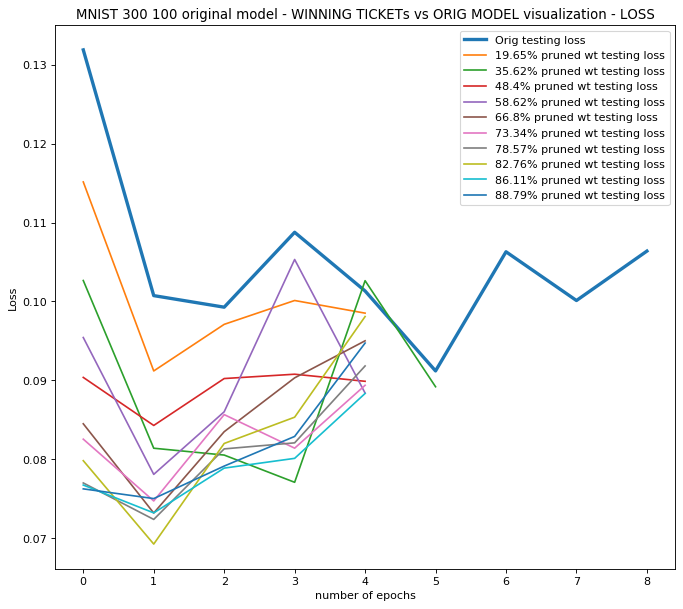

In [29]:
# Visualize neural network which is to be pruned off-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history_orig.history['val_loss'], label = 'Orig testing loss',linewidth=3.0)

for i in range(10):
    plt.plot(history_main[i+1]['val_loss'], label = '{}% pruned wt testing loss'.format(history_main[i+1]['percentage_wts_pruned'][0]))
    
    
plt.title("MNIST 300 100 original model - WINNING TICKETs vs ORIG MODEL visualization - LOSS")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend(loc = 'best')
plt.show()

In [31]:
1000/266000*100

0.37593984962406013

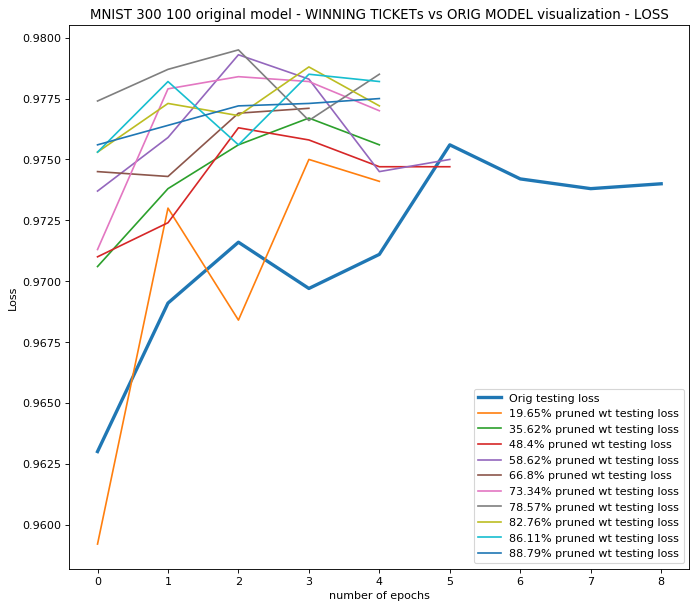

In [43]:
# Visualize neural network which is to be pruned off-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history_orig.history['val_accuracy'], label = 'Orig testing loss',linewidth=3.0)

for i in range(10):
    plt.plot(history_main[i+1]['val_accuracy'], label = '{}% pruned wt testing loss'.format(history_main[i+1]['percentage_wts_pruned'][0]))
    
    
plt.title("MNIST 300 100 original model - WINNING TICKETs vs ORIG MODEL visualization - LOSS")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend(loc = 'best')
plt.show()